In [55]:
import keras
from keras.layers import Input, Conv1D,Activation,MaxPooling1D,Dense,Flatten,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

In [60]:
def get_sub_model(myinputs,channel=3):
    x     = Conv1D(filters =16, kernel_size=5,strides = 1, padding = 'same')(myinputs)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=3,strides = 2,padding='same')(x)
    #  x shape is 64X48 =3072
    x     = Conv1D(filters =24, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    #  x shape is 32X64 = 2048
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 16*96 = 1536
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 8*128 = 1024
    x     = Conv1D(filters =48, kernel_size=3,strides = 2, padding = 'same')(x)
    # x shape is 4*128 = 512

    latent_vector = Flatten()(x)
    # decoder x = 4*128
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 8*128
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 16*96
    x     = Conv1D(filters =24, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 32*64
    x     = Conv1D(filters =16, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 64*48
    x     = Conv1D(filters =16, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 128*48
    y     = Conv1D(filters =channel, kernel_size=3,strides = 1, padding = 'same')(x)
    return latent_vector,y

In [61]:
def build_model(name="push_detect",channel=3):
    # input shape 128X26 =3382
    with tf.name_scope(name):
        myInputs = Input(shape=(128,channel))
                
        LV,Y = get_sub_model(myInputs,channel=channel)
        
        autoencoder = Model (inputs=myInputs,
                             outputs =Y)
    
    return autoencoder

In [86]:
gyroModel=build_model()
linearAccModel=build_model()
gravityModel=build_model()
gameVecModel=build_model(channel=4)
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
gyroModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
linearAccModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.00001, momentum=0.0, decay=0.0, nesterov=False)
gravityModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
gameVecModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

In [84]:
data= np.load('watch.npy')
np.random.shuffle(data)
p=0.85
train_num =int(data.shape[0]*p)
gyro_train=data[:train_num,:,13:16]
linearAcc_train=data[:train_num,:,16:19]
gravity_train=data[:train_num,:,19:22]
gameVec_train=data[:train_num,:,22:26]

gyro_test =data[train_num:,:,13:16]
linearAcc_test =data[train_num:,:,16:19]
gravity_test =data[train_num:,:,19:22]
gameVec_test =data[train_num:,:,22:26]

In [93]:
for i in range(30):
    print('start training round '+str(i))
    print('training gyro model')
    gyroModel.fit(gyro_train,gyro_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training linearAcc model')
    linearAccModel.fit(linearAcc_train,linearAcc_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gravity model')
    gravityModel.fit(gravity_train,gravity_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gameVec model')
    gameVecModel.fit(gameVec_train,gameVec_train,batch_size=256,epochs=50,validation_split=0.1)
    gyroModel.save('gyroModelFFT.h5')
    linearAccModel.save('linearAccModelFFT.h5')
    gravityModel.save('gravityModelFFT.h5')
    gameVecModel.save('gameVecModelFFT.h5')

start training round 0
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 378us/step - loss: 35.5028 - acc: 0.6913 - val_loss: 33.3562 - val_acc: 0.6760
Epoch 2/50
8564/8564 [==============================] - 3s 377us/step - loss: 34.4216 - acc: 0.6901 - val_loss: 34.3767 - val_acc: 0.6748
Epoch 3/50
8564/8564 [==============================] - 3s 395us/step - loss: 35.0050 - acc: 0.6885 - val_loss: 37.4822 - val_acc: 0.6763
Epoch 4/50
8564/8564 [==============================] - 3s 391us/step - loss: 35.4059 - acc: 0.6849 - val_loss: 34.4512 - val_acc: 0.6776
Epoch 5/50
8564/8564 [==============================] - 3s 378us/step - loss: 34.2718 - acc: 0.6840 - val_loss: 36.5376 - val_acc: 0.6694
Epoch 6/50
8564/8564 [==============================] - 3s 391us/step - loss: 35.1953 - acc: 0.6851 - val_loss: 33.4377 - val_acc: 0.6781
Epoch 7/50
8564/8564 [==============================] - 3s 390us/step - loss: 34.3

8564/8564 [==============================] - 3s 380us/step - loss: 126.6363 - acc: 0.6251 - val_loss: 124.5226 - val_acc: 0.6219
Epoch 9/50
8564/8564 [==============================] - 3s 378us/step - loss: 124.4778 - acc: 0.6234 - val_loss: 127.4210 - val_acc: 0.6163
Epoch 10/50
8564/8564 [==============================] - 3s 369us/step - loss: 124.7380 - acc: 0.6225 - val_loss: 125.2810 - val_acc: 0.6193
Epoch 11/50
8564/8564 [==============================] - 3s 371us/step - loss: 125.0964 - acc: 0.6251 - val_loss: 127.4831 - val_acc: 0.6194
Epoch 12/50
8564/8564 [==============================] - 3s 370us/step - loss: 127.3175 - acc: 0.6248 - val_loss: 128.8018 - val_acc: 0.6191
Epoch 13/50
8564/8564 [==============================] - 3s 376us/step - loss: 127.5771 - acc: 0.6240 - val_loss: 124.7365 - val_acc: 0.6198
Epoch 14/50
8564/8564 [==============================] - 3s 370us/step - loss: 124.3771 - acc: 0.6258 - val_loss: 124.5413 - val_acc: 0.6200
Epoch 15/50
8564/8564 [===

Epoch 16/50
8564/8564 [==============================] - 3s 379us/step - loss: 60.0654 - acc: 0.4269 - val_loss: 56.1122 - val_acc: 0.4324
Epoch 17/50
8564/8564 [==============================] - 3s 391us/step - loss: 60.0334 - acc: 0.4268 - val_loss: 56.1102 - val_acc: 0.4322
Epoch 18/50
8564/8564 [==============================] - 3s 388us/step - loss: 60.0021 - acc: 0.4266 - val_loss: 56.0656 - val_acc: 0.4317
Epoch 19/50
8564/8564 [==============================] - 3s 366us/step - loss: 59.9727 - acc: 0.4276 - val_loss: 56.0445 - val_acc: 0.4292
Epoch 20/50
8564/8564 [==============================] - 3s 362us/step - loss: 59.9432 - acc: 0.4264 - val_loss: 56.0084 - val_acc: 0.4322
Epoch 21/50
8564/8564 [==============================] - 3s 382us/step - loss: 59.9134 - acc: 0.4270 - val_loss: 55.9724 - val_acc: 0.4317
Epoch 22/50
8564/8564 [==============================] - 3s 376us/step - loss: 59.8781 - acc: 0.4274 - val_loss: 55.9483 - val_acc: 0.4315
Epoch 23/50
8564/8564 [====

Epoch 25/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.5655 - acc: 0.4340 - val_loss: 0.5271 - val_acc: 0.4339
Epoch 26/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.5653 - acc: 0.4338 - val_loss: 0.5271 - val_acc: 0.4343
Epoch 27/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.5653 - acc: 0.4340 - val_loss: 0.5273 - val_acc: 0.4339
Epoch 28/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.5654 - acc: 0.4340 - val_loss: 0.5268 - val_acc: 0.4341
Epoch 29/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.5648 - acc: 0.4341 - val_loss: 0.5265 - val_acc: 0.4342
Epoch 30/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.5647 - acc: 0.4344 - val_loss: 0.5266 - val_acc: 0.4343
Epoch 31/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.5644 - acc: 0.4340 - val_loss: 0.5279 - val_acc: 0.4349
Epoch 32/50
8564/8564 [==================

Epoch 34/50
8564/8564 [==============================] - 2s 216us/step - loss: 34.9784 - acc: 0.6788 - val_loss: 34.6354 - val_acc: 0.6734
Epoch 35/50
8564/8564 [==============================] - 2s 216us/step - loss: 33.9940 - acc: 0.6798 - val_loss: 34.5166 - val_acc: 0.6716
Epoch 36/50
8564/8564 [==============================] - 2s 217us/step - loss: 34.2093 - acc: 0.6792 - val_loss: 34.8232 - val_acc: 0.6714
Epoch 37/50
8564/8564 [==============================] - 2s 218us/step - loss: 33.8918 - acc: 0.6827 - val_loss: 34.4532 - val_acc: 0.6787
Epoch 38/50
8564/8564 [==============================] - 2s 217us/step - loss: 34.1813 - acc: 0.6792 - val_loss: 33.0153 - val_acc: 0.6802
Epoch 39/50
8564/8564 [==============================] - 2s 219us/step - loss: 34.1052 - acc: 0.6788 - val_loss: 33.4136 - val_acc: 0.6814
Epoch 40/50
8564/8564 [==============================] - 2s 218us/step - loss: 34.3554 - acc: 0.6799 - val_loss: 33.7875 - val_acc: 0.6811
Epoch 41/50
8564/8564 [====

Epoch 42/50
8564/8564 [==============================] - 2s 215us/step - loss: 122.4789 - acc: 0.6238 - val_loss: 122.4179 - val_acc: 0.6214
Epoch 43/50
8564/8564 [==============================] - 2s 215us/step - loss: 121.2147 - acc: 0.6247 - val_loss: 121.5376 - val_acc: 0.6225
Epoch 44/50
8564/8564 [==============================] - 2s 215us/step - loss: 121.1343 - acc: 0.6259 - val_loss: 122.5025 - val_acc: 0.6211
Epoch 45/50
8564/8564 [==============================] - 2s 214us/step - loss: 122.2245 - acc: 0.6251 - val_loss: 125.0517 - val_acc: 0.6221
Epoch 46/50
8564/8564 [==============================] - 2s 215us/step - loss: 124.7725 - acc: 0.6272 - val_loss: 122.5788 - val_acc: 0.6231
Epoch 47/50
8564/8564 [==============================] - 2s 215us/step - loss: 123.3546 - acc: 0.6272 - val_loss: 125.5214 - val_acc: 0.6205
Epoch 48/50
8564/8564 [==============================] - 2s 215us/step - loss: 125.7786 - acc: 0.6253 - val_loss: 125.1574 - val_acc: 0.6218
Epoch 49/50
8

8564/8564 [==============================] - 2s 219us/step - loss: 57.9308 - acc: 0.4298 - val_loss: 54.1267 - val_acc: 0.4354
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.5611 - acc: 0.4350 - val_loss: 0.5250 - val_acc: 0.4366
Epoch 2/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.5613 - acc: 0.4348 - val_loss: 0.5233 - val_acc: 0.4361
Epoch 3/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.5607 - acc: 0.4350 - val_loss: 0.5231 - val_acc: 0.4358
Epoch 4/50
8564/8564 [==============================] - 2s 221us/step - loss: 0.5605 - acc: 0.4351 - val_loss: 0.5235 - val_acc: 0.4361
Epoch 5/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.5604 - acc: 0.4350 - val_loss: 0.5227 - val_acc: 0.4355
Epoch 6/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.5611 - acc: 0.4349 - val_loss: 0.5225 - val

Epoch 9/50
8564/8564 [==============================] - 2s 217us/step - loss: 34.3173 - acc: 0.6799 - val_loss: 32.8104 - val_acc: 0.6815
Epoch 10/50
8564/8564 [==============================] - 2s 217us/step - loss: 33.9221 - acc: 0.6798 - val_loss: 34.5430 - val_acc: 0.6796
Epoch 11/50
8564/8564 [==============================] - 2s 214us/step - loss: 33.9579 - acc: 0.6814 - val_loss: 34.5020 - val_acc: 0.6777
Epoch 12/50
8564/8564 [==============================] - 2s 213us/step - loss: 34.2649 - acc: 0.6799 - val_loss: 33.5764 - val_acc: 0.6774
Epoch 13/50
8564/8564 [==============================] - 2s 219us/step - loss: 33.3301 - acc: 0.6802 - val_loss: 33.6875 - val_acc: 0.6804
Epoch 14/50
8564/8564 [==============================] - 2s 216us/step - loss: 34.4324 - acc: 0.6798 - val_loss: 32.4062 - val_acc: 0.6818
Epoch 15/50
8564/8564 [==============================] - 2s 213us/step - loss: 33.9440 - acc: 0.6792 - val_loss: 34.7916 - val_acc: 0.6826
Epoch 16/50
8564/8564 [=====

8564/8564 [==============================] - 2s 217us/step - loss: 125.5385 - acc: 0.6273 - val_loss: 127.8603 - val_acc: 0.6200
Epoch 18/50
8564/8564 [==============================] - 2s 214us/step - loss: 121.7963 - acc: 0.6267 - val_loss: 122.0423 - val_acc: 0.6221
Epoch 19/50
8564/8564 [==============================] - 2s 216us/step - loss: 121.7139 - acc: 0.6274 - val_loss: 129.0706 - val_acc: 0.6217
Epoch 20/50
8564/8564 [==============================] - 2s 220us/step - loss: 123.7792 - acc: 0.6252 - val_loss: 123.6122 - val_acc: 0.6220
Epoch 21/50
8564/8564 [==============================] - 2s 213us/step - loss: 121.1384 - acc: 0.6285 - val_loss: 127.0696 - val_acc: 0.6219
Epoch 22/50
8564/8564 [==============================] - 2s 215us/step - loss: 123.6311 - acc: 0.6271 - val_loss: 124.5800 - val_acc: 0.6222
Epoch 23/50
8564/8564 [==============================] - 2s 212us/step - loss: 121.8689 - acc: 0.6269 - val_loss: 122.0786 - val_acc: 0.6179
Epoch 24/50
8564/8564 [==

8564/8564 [==============================] - 2s 217us/step - loss: 57.4127 - acc: 0.4291 - val_loss: 53.6274 - val_acc: 0.4355
Epoch 26/50
8564/8564 [==============================] - 2s 216us/step - loss: 57.3952 - acc: 0.4303 - val_loss: 53.6106 - val_acc: 0.4352
Epoch 27/50
8564/8564 [==============================] - 2s 219us/step - loss: 57.3747 - acc: 0.4298 - val_loss: 53.5646 - val_acc: 0.4327
Epoch 28/50
8564/8564 [==============================] - 2s 219us/step - loss: 57.3466 - acc: 0.4296 - val_loss: 53.5560 - val_acc: 0.4348
Epoch 29/50
8564/8564 [==============================] - 2s 219us/step - loss: 57.3308 - acc: 0.4299 - val_loss: 53.5403 - val_acc: 0.4346
Epoch 30/50
8564/8564 [==============================] - 2s 218us/step - loss: 57.3096 - acc: 0.4297 - val_loss: 53.5194 - val_acc: 0.4347
Epoch 31/50
8564/8564 [==============================] - 2s 216us/step - loss: 57.2828 - acc: 0.4301 - val_loss: 53.4862 - val_acc: 0.4337
Epoch 32/50
8564/8564 [================

8564/8564 [==============================] - 2s 226us/step - loss: 0.5477 - acc: 0.4383 - val_loss: 0.5118 - val_acc: 0.4394
Epoch 35/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.5477 - acc: 0.4380 - val_loss: 0.5116 - val_acc: 0.4394
Epoch 36/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.5477 - acc: 0.4383 - val_loss: 0.5115 - val_acc: 0.4393
Epoch 37/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.5473 - acc: 0.4384 - val_loss: 0.5118 - val_acc: 0.4398
Epoch 38/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.5471 - acc: 0.4385 - val_loss: 0.5118 - val_acc: 0.4395
Epoch 39/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.5477 - acc: 0.4387 - val_loss: 0.5111 - val_acc: 0.4393
Epoch 40/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.5468 - acc: 0.4385 - val_loss: 0.5112 - val_acc: 0.4393
Epoch 41/50
8564/8564 [==============================

Epoch 43/50
8564/8564 [==============================] - 3s 377us/step - loss: 33.0735 - acc: 0.6794 - val_loss: 34.1046 - val_acc: 0.6823
Epoch 44/50
8564/8564 [==============================] - 3s 385us/step - loss: 33.5108 - acc: 0.6793 - val_loss: 36.3314 - val_acc: 0.6832
Epoch 45/50
8564/8564 [==============================] - 3s 368us/step - loss: 33.6552 - acc: 0.6821 - val_loss: 33.1734 - val_acc: 0.7102
Epoch 46/50
8564/8564 [==============================] - 3s 376us/step - loss: 32.9066 - acc: 0.6828 - val_loss: 32.2032 - val_acc: 0.6788
Epoch 47/50
8564/8564 [==============================] - 3s 378us/step - loss: 32.7913 - acc: 0.6794 - val_loss: 34.5951 - val_acc: 0.6830
Epoch 48/50
8564/8564 [==============================] - 3s 377us/step - loss: 33.6642 - acc: 0.6798 - val_loss: 34.2763 - val_acc: 0.6843
Epoch 49/50
8564/8564 [==============================] - 3s 384us/step - loss: 34.0729 - acc: 0.6811 - val_loss: 33.3917 - val_acc: 0.7102
Epoch 50/50
8564/8564 [====

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 366us/step - loss: 56.8898 - acc: 0.4301 - val_loss: 53.1341 - val_acc: 0.4345
Epoch 2/50
8564/8564 [==============================] - 3s 387us/step - loss: 56.8693 - acc: 0.4299 - val_loss: 53.1086 - val_acc: 0.4340
Epoch 3/50
8564/8564 [==============================] - 3s 376us/step - loss: 56.8445 - acc: 0.4302 - val_loss: 53.0944 - val_acc: 0.4350
Epoch 4/50
8564/8564 [==============================] - 3s 394us/step - loss: 56.8274 - acc: 0.4300 - val_loss: 53.0880 - val_acc: 0.4353
Epoch 5/50
8564/8564 [==============================] - 3s 380us/step - loss: 56.8070 - acc: 0.4302 - val_loss: 53.0632 - val_acc: 0.4338
Epoch 6/50
8564/8564 [==============================] - 3s 375us/step - loss: 56.7891 - acc: 0.4300 - val_loss: 53.0509 - val_acc: 0.4349
Epoch 7/50
8564/8564 [==============================] - 3s 376us/step - loss: 56.7670 - acc: 0.4302 - 

8564/8564 [==============================] - 3s 388us/step - loss: 0.5443 - acc: 0.4396 - val_loss: 0.5087 - val_acc: 0.4406
Epoch 10/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.5440 - acc: 0.4399 - val_loss: 0.5094 - val_acc: 0.4410
Epoch 11/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.5444 - acc: 0.4398 - val_loss: 0.5102 - val_acc: 0.4415
Epoch 12/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.5448 - acc: 0.4398 - val_loss: 0.5088 - val_acc: 0.4411
Epoch 13/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.5436 - acc: 0.4401 - val_loss: 0.5105 - val_acc: 0.4402
Epoch 14/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.5436 - acc: 0.4399 - val_loss: 0.5082 - val_acc: 0.4412
Epoch 15/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.5434 - acc: 0.4399 - val_loss: 0.5079 - val_acc: 0.4416
Epoch 16/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 368us/step - loss: 33.0666 - acc: 0.6801 - val_loss: 33.2997 - val_acc: 0.6849
Epoch 19/50
8564/8564 [==============================] - 3s 366us/step - loss: 33.2947 - acc: 0.6809 - val_loss: 32.8982 - val_acc: 0.6808
Epoch 20/50
8564/8564 [==============================] - 3s 372us/step - loss: 33.0771 - acc: 0.6798 - val_loss: 34.0967 - val_acc: 0.6825
Epoch 21/50
8564/8564 [==============================] - 3s 361us/step - loss: 32.9412 - acc: 0.6811 - val_loss: 32.4896 - val_acc: 0.6868
Epoch 22/50
8564/8564 [==============================] - 3s 378us/step - loss: 33.3559 - acc: 0.6806 - val_loss: 32.6520 - val_acc: 0.6841
Epoch 23/50
8564/8564 [==============================] - 3s 376us/step - loss: 32.7100 - acc: 0.6802 - val_loss: 33.1986 - val_acc: 0.6825
Epoch 24/50
8564/8564 [==============================] - 3s 365us/step - loss: 33.3898 - acc: 0.6802 - val_loss: 33.5302 - val_acc: 0.6821
Epoch 25/50
8564/8564 [================

8564/8564 [==============================] - 3s 374us/step - loss: 117.5612 - acc: 0.6273 - val_loss: 118.3946 - val_acc: 0.6247
Epoch 27/50
8564/8564 [==============================] - 3s 367us/step - loss: 120.8733 - acc: 0.6285 - val_loss: 120.1385 - val_acc: 0.6246
Epoch 28/50
8564/8564 [==============================] - 3s 370us/step - loss: 122.0783 - acc: 0.6297 - val_loss: 119.4060 - val_acc: 0.6259
Epoch 29/50
8564/8564 [==============================] - 3s 363us/step - loss: 120.5272 - acc: 0.6297 - val_loss: 123.2873 - val_acc: 0.6244
Epoch 30/50
8564/8564 [==============================] - 3s 375us/step - loss: 120.7294 - acc: 0.6286 - val_loss: 121.7190 - val_acc: 0.6212
Epoch 31/50
8564/8564 [==============================] - 3s 369us/step - loss: 120.2862 - acc: 0.6291 - val_loss: 121.4963 - val_acc: 0.6245
Epoch 32/50
8564/8564 [==============================] - 3s 365us/step - loss: 119.7205 - acc: 0.6298 - val_loss: 120.1396 - val_acc: 0.6215
Epoch 33/50
8564/8564 [==

8564/8564 [==============================] - 3s 378us/step - loss: 55.5182 - acc: 0.4309 - val_loss: 51.9025 - val_acc: 0.4349
Epoch 35/50
8564/8564 [==============================] - 3s 378us/step - loss: 55.5082 - acc: 0.4309 - val_loss: 51.8861 - val_acc: 0.4350
Epoch 36/50
8564/8564 [==============================] - 3s 373us/step - loss: 55.4955 - acc: 0.4307 - val_loss: 51.8919 - val_acc: 0.4365
Epoch 37/50
8564/8564 [==============================] - 3s 373us/step - loss: 55.4857 - acc: 0.4309 - val_loss: 51.8621 - val_acc: 0.4354
Epoch 38/50
8564/8564 [==============================] - 3s 372us/step - loss: 55.4610 - acc: 0.4309 - val_loss: 51.8482 - val_acc: 0.4353
Epoch 39/50
8564/8564 [==============================] - 3s 380us/step - loss: 55.4478 - acc: 0.4304 - val_loss: 51.8711 - val_acc: 0.4368
Epoch 40/50
8564/8564 [==============================] - 3s 374us/step - loss: 55.4409 - acc: 0.4313 - val_loss: 51.8199 - val_acc: 0.4361
Epoch 41/50
8564/8564 [================

8564/8564 [==============================] - 3s 388us/step - loss: 0.5325 - acc: 0.4444 - val_loss: 0.4987 - val_acc: 0.4459
Epoch 44/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.5324 - acc: 0.4444 - val_loss: 0.4995 - val_acc: 0.4447
Epoch 45/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.5324 - acc: 0.4444 - val_loss: 0.5011 - val_acc: 0.4456
Epoch 46/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.5337 - acc: 0.4446 - val_loss: 0.4994 - val_acc: 0.4448
Epoch 47/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.5320 - acc: 0.4446 - val_loss: 0.4982 - val_acc: 0.4458
Epoch 48/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.5325 - acc: 0.4445 - val_loss: 0.4982 - val_acc: 0.4458
Epoch 49/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.5317 - acc: 0.4447 - val_loss: 0.4980 - val_acc: 0.4461
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 374us/step - loss: 118.3273 - acc: 0.6277 - val_loss: 121.1745 - val_acc: 0.6222
Epoch 2/50
8564/8564 [==============================] - 3s 372us/step - loss: 117.9647 - acc: 0.6273 - val_loss: 120.0525 - val_acc: 0.6205
Epoch 3/50
8564/8564 [==============================] - 3s 380us/step - loss: 117.3931 - acc: 0.6298 - val_loss: 118.8472 - val_acc: 0.6250
Epoch 4/50
8564/8564 [==============================] - 3s 367us/step - loss: 120.2947 - acc: 0.6302 - val_loss: 122.6902 - val_acc: 0.6261
Epoch 5/50
8564/8564 [==============================] - 3s 378us/step - loss: 122.0914 - acc: 0.6303 - val_loss: 118.9598 - val_acc: 0.6256
Epoch 6/50
8564/8564 [==============================] - 3s 371us/step - loss: 119.0851 - acc: 0.6277 - val_loss: 122.3656 - val_acc: 0.6222
Epoch 7/50
8564/8564 [==============================] - 3s 378us/step - loss: 120.0899 - acc: 0.6286 - val_loss: 118.3751 - val_acc: 0.6268
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 3s 376us/step - loss: 55.1842 - acc: 0.4314 - val_loss: 51.5962 - val_acc: 0.4350
Epoch 10/50
8564/8564 [==============================] - 3s 364us/step - loss: 55.1723 - acc: 0.4311 - val_loss: 51.5922 - val_acc: 0.4364
Epoch 11/50
8564/8564 [==============================] - 3s 372us/step - loss: 55.1585 - acc: 0.4312 - val_loss: 51.5730 - val_acc: 0.4359
Epoch 12/50
8564/8564 [==============================] - 3s 390us/step - loss: 55.1468 - acc: 0.4311 - val_loss: 51.5651 - val_acc: 0.4352
Epoch 13/50
8564/8564 [==============================] - 3s 378us/step - loss: 55.1299 - acc: 0.4313 - val_loss: 51.5445 - val_acc: 0.4350
Epoch 14/50
8564/8564 [==============================] - 3s 371us/step - loss: 55.1151 - acc: 0.4309 - val_loss: 51.5379 - val_acc: 0.4361
Epoch 15/50
8564/8564 [==============================] - 3s 364us/step - loss: 55.1020 - acc: 0.4313 - val_loss: 51.5394 - val_acc: 0.4367
Epoch 16/50
8564/8564 [=====

Epoch 18/50
8564/8564 [==============================] - 3s 373us/step - loss: 0.5307 - acc: 0.4456 - val_loss: 0.4956 - val_acc: 0.4472
Epoch 19/50
8564/8564 [==============================] - 3s 401us/step - loss: 0.5299 - acc: 0.4457 - val_loss: 0.4961 - val_acc: 0.4466
Epoch 20/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.5293 - acc: 0.4458 - val_loss: 0.4963 - val_acc: 0.4473
Epoch 21/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.5296 - acc: 0.4457 - val_loss: 0.4957 - val_acc: 0.4470
Epoch 22/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.5294 - acc: 0.4459 - val_loss: 0.4952 - val_acc: 0.4469
Epoch 23/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.5286 - acc: 0.4460 - val_loss: 0.4964 - val_acc: 0.4462
Epoch 24/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.5306 - acc: 0.4458 - val_loss: 0.4950 - val_acc: 0.4471
Epoch 25/50
8564/8564 [==================

Epoch 27/50
8564/8564 [==============================] - 3s 378us/step - loss: 31.1260 - acc: 0.6798 - val_loss: 31.5373 - val_acc: 0.6817
Epoch 28/50
8564/8564 [==============================] - 3s 370us/step - loss: 32.7655 - acc: 0.6786 - val_loss: 32.0192 - val_acc: 0.6844
Epoch 29/50
8564/8564 [==============================] - 3s 373us/step - loss: 32.2027 - acc: 0.6798 - val_loss: 32.5541 - val_acc: 0.6833
Epoch 30/50
8564/8564 [==============================] - 3s 372us/step - loss: 32.4231 - acc: 0.6813 - val_loss: 31.4600 - val_acc: 0.6843
Epoch 31/50
8564/8564 [==============================] - 3s 369us/step - loss: 31.8906 - acc: 0.6794 - val_loss: 32.0230 - val_acc: 0.6831
Epoch 32/50
8564/8564 [==============================] - 3s 372us/step - loss: 32.2011 - acc: 0.6793 - val_loss: 31.3991 - val_acc: 0.6794
Epoch 33/50
8564/8564 [==============================] - 3s 370us/step - loss: 32.1282 - acc: 0.6794 - val_loss: 31.9209 - val_acc: 0.6840
Epoch 34/50
8564/8564 [====

Epoch 35/50
8564/8564 [==============================] - 3s 378us/step - loss: 120.8258 - acc: 0.6315 - val_loss: 119.1139 - val_acc: 0.6266
Epoch 36/50
8564/8564 [==============================] - 3s 379us/step - loss: 117.8170 - acc: 0.6302 - val_loss: 116.9632 - val_acc: 0.6265
Epoch 37/50
8564/8564 [==============================] - 3s 371us/step - loss: 116.2754 - acc: 0.6270 - val_loss: 117.7427 - val_acc: 0.6199
Epoch 38/50
8564/8564 [==============================] - 3s 378us/step - loss: 115.7530 - acc: 0.6302 - val_loss: 115.8669 - val_acc: 0.6283
Epoch 39/50
8564/8564 [==============================] - 3s 365us/step - loss: 116.0824 - acc: 0.6309 - val_loss: 120.7630 - val_acc: 0.6279
Epoch 40/50
8564/8564 [==============================] - 3s 367us/step - loss: 119.1568 - acc: 0.6328 - val_loss: 116.0533 - val_acc: 0.6282
Epoch 41/50
8564/8564 [==============================] - 3s 367us/step - loss: 119.9755 - acc: 0.6326 - val_loss: 118.0078 - val_acc: 0.6281
Epoch 42/50
8

8564/8564 [==============================] - 3s 379us/step - loss: 54.1741 - acc: 0.4313 - val_loss: 50.6593 - val_acc: 0.4367
Epoch 44/50
8564/8564 [==============================] - 3s 370us/step - loss: 54.1637 - acc: 0.4314 - val_loss: 50.6562 - val_acc: 0.4371
Epoch 45/50
8564/8564 [==============================] - 3s 378us/step - loss: 54.1547 - acc: 0.4320 - val_loss: 50.6352 - val_acc: 0.4367
Epoch 46/50
8564/8564 [==============================] - 3s 375us/step - loss: 54.1444 - acc: 0.4316 - val_loss: 50.6501 - val_acc: 0.4376
Epoch 47/50
8564/8564 [==============================] - 3s 393us/step - loss: 54.1361 - acc: 0.4318 - val_loss: 50.6275 - val_acc: 0.4371
Epoch 48/50
8564/8564 [==============================] - 3s 379us/step - loss: 54.1205 - acc: 0.4316 - val_loss: 50.6170 - val_acc: 0.4373
Epoch 49/50
8564/8564 [==============================] - 3s 364us/step - loss: 54.1090 - acc: 0.4319 - val_loss: 50.6073 - val_acc: 0.4372
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 3s 365us/step - loss: 32.4342 - acc: 0.6780 - val_loss: 34.1179 - val_acc: 0.6702
Epoch 2/50
8564/8564 [==============================] - 3s 375us/step - loss: 32.1170 - acc: 0.6800 - val_loss: 35.6864 - val_acc: 0.6671
Epoch 3/50
8564/8564 [==============================] - 3s 371us/step - loss: 32.2324 - acc: 0.6785 - val_loss: 30.9786 - val_acc: 0.6777
Epoch 4/50
8564/8564 [==============================] - 3s 366us/step - loss: 31.7911 - acc: 0.6788 - val_loss: 31.3537 - val_acc: 0.6848
Epoch 5/50
8564/8564 [==============================] - 3s 381us/step - loss: 32.2644 - acc: 0.6797 - val_loss: 31.1849 - val_acc: 0.6805
Epoch 6/50
8564/8564 [==============================] - 3s 372us/step - loss: 31.8046 - acc: 0.6793 - val_loss: 31.7368 - val_acc: 0.6824
Epoch 7/50
8564/8564 [==============================] - 3s 368us/step - loss: 32.0355 - acc: 0.6798 - val_loss: 32.4143 - val_acc: 0.6819
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 3s 382us/step - loss: 119.5098 - acc: 0.6321 - val_loss: 119.2835 - val_acc: 0.6282
Epoch 10/50
8564/8564 [==============================] - 3s 377us/step - loss: 119.0760 - acc: 0.6329 - val_loss: 123.8230 - val_acc: 0.6266
Epoch 11/50
8564/8564 [==============================] - 3s 375us/step - loss: 117.0204 - acc: 0.6336 - val_loss: 119.1793 - val_acc: 0.6283
Epoch 12/50
8564/8564 [==============================] - 3s 380us/step - loss: 118.0486 - acc: 0.6323 - val_loss: 117.0998 - val_acc: 0.6275
Epoch 13/50
8564/8564 [==============================] - 3s 364us/step - loss: 117.1429 - acc: 0.6310 - val_loss: 121.5678 - val_acc: 0.6243
Epoch 14/50
8564/8564 [==============================] - 3s 379us/step - loss: 119.2214 - acc: 0.6314 - val_loss: 119.7948 - val_acc: 0.6257
Epoch 15/50
8564/8564 [==============================] - 3s 374us/step - loss: 116.9646 - acc: 0.6293 - val_loss: 114.5417 - val_acc: 0.6285
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 3s 372us/step - loss: 53.9216 - acc: 0.4322 - val_loss: 50.4187 - val_acc: 0.4376
Epoch 18/50
8564/8564 [==============================] - 3s 394us/step - loss: 53.9082 - acc: 0.4320 - val_loss: 50.4248 - val_acc: 0.4386
Epoch 19/50
8564/8564 [==============================] - 4s 410us/step - loss: 53.8958 - acc: 0.4322 - val_loss: 50.3987 - val_acc: 0.4379
Epoch 20/50
8564/8564 [==============================] - 3s 397us/step - loss: 53.8845 - acc: 0.4321 - val_loss: 50.3847 - val_acc: 0.4371
Epoch 21/50
8564/8564 [==============================] - 3s 392us/step - loss: 53.8731 - acc: 0.4321 - val_loss: 50.3880 - val_acc: 0.4372
Epoch 22/50
8564/8564 [==============================] - 3s 387us/step - loss: 53.8670 - acc: 0.4320 - val_loss: 50.3674 - val_acc: 0.4382
Epoch 23/50
8564/8564 [==============================] - 3s 385us/step - loss: 53.8539 - acc: 0.4323 - val_loss: 50.3581 - val_acc: 0.4381
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.5148 - acc: 0.4503 - val_loss: 0.4824 - val_acc: 0.4509
Epoch 27/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.5135 - acc: 0.4505 - val_loss: 0.4831 - val_acc: 0.4515
Epoch 28/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.5140 - acc: 0.4504 - val_loss: 0.4826 - val_acc: 0.4510
Epoch 29/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.5135 - acc: 0.4505 - val_loss: 0.4825 - val_acc: 0.4516
Epoch 30/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.5129 - acc: 0.4506 - val_loss: 0.4822 - val_acc: 0.4516
Epoch 31/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.5134 - acc: 0.4504 - val_loss: 0.4826 - val_acc: 0.4510
Epoch 32/50
8564/8564 [==============================] - 3s 407us/step - loss: 0.5132 - acc: 0.4505 - val_loss: 0.4820 - val_acc: 0.4517
Epoch 33/50
8564/8564 [==================

Epoch 35/50
8564/8564 [==============================] - 3s 389us/step - loss: 31.4405 - acc: 0.6783 - val_loss: 33.0848 - val_acc: 0.6697
Epoch 36/50
8564/8564 [==============================] - 3s 380us/step - loss: 31.9633 - acc: 0.6775 - val_loss: 33.2510 - val_acc: 0.6751
Epoch 37/50
8564/8564 [==============================] - 3s 382us/step - loss: 31.6919 - acc: 0.6787 - val_loss: 31.2441 - val_acc: 0.6673
Epoch 38/50
8564/8564 [==============================] - 3s 383us/step - loss: 31.3593 - acc: 0.6778 - val_loss: 31.1147 - val_acc: 0.6769
Epoch 39/50
8564/8564 [==============================] - 3s 378us/step - loss: 31.0791 - acc: 0.6784 - val_loss: 33.3467 - val_acc: 0.6666
Epoch 40/50
8564/8564 [==============================] - 3s 376us/step - loss: 31.6750 - acc: 0.6779 - val_loss: 31.4717 - val_acc: 0.6740
Epoch 41/50
8564/8564 [==============================] - 3s 379us/step - loss: 31.3745 - acc: 0.6774 - val_loss: 33.2153 - val_acc: 0.6601
Epoch 42/50
8564/8564 [====

Epoch 43/50
8564/8564 [==============================] - 3s 373us/step - loss: 119.5620 - acc: 0.6341 - val_loss: 117.5329 - val_acc: 0.6307
Epoch 44/50
8564/8564 [==============================] - 3s 368us/step - loss: 116.9617 - acc: 0.6334 - val_loss: 122.8928 - val_acc: 0.6202
Epoch 45/50
8564/8564 [==============================] - 3s 376us/step - loss: 115.9554 - acc: 0.6311 - val_loss: 118.7147 - val_acc: 0.6289
Epoch 46/50
8564/8564 [==============================] - 3s 381us/step - loss: 116.8175 - acc: 0.6343 - val_loss: 117.3642 - val_acc: 0.6314
Epoch 47/50
8564/8564 [==============================] - 3s 378us/step - loss: 114.8965 - acc: 0.6333 - val_loss: 115.7800 - val_acc: 0.6293
Epoch 48/50
8564/8564 [==============================] - 3s 363us/step - loss: 113.9995 - acc: 0.6343 - val_loss: 116.5570 - val_acc: 0.6277
Epoch 49/50
8564/8564 [==============================] - 3s 371us/step - loss: 114.4228 - acc: 0.6303 - val_loss: 114.3222 - val_acc: 0.6289
Epoch 50/50
8

8564/8564 [==============================] - 3s 379us/step - loss: 0.5115 - acc: 0.4510 - val_loss: 0.4817 - val_acc: 0.4515
Epoch 2/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.5101 - acc: 0.4514 - val_loss: 0.4797 - val_acc: 0.4515
Epoch 3/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.5101 - acc: 0.4513 - val_loss: 0.4797 - val_acc: 0.4519
Epoch 4/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.5100 - acc: 0.4514 - val_loss: 0.4795 - val_acc: 0.4516
Epoch 5/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.5103 - acc: 0.4515 - val_loss: 0.4794 - val_acc: 0.4520
Epoch 6/50
8564/8564 [==============================] - 3s 374us/step - loss: 0.5094 - acc: 0.4518 - val_loss: 0.4805 - val_acc: 0.4518
Epoch 7/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.5109 - acc: 0.4513 - val_loss: 0.4796 - val_acc: 0.4519
Epoch 8/50
8564/8564 [==============================] - 3s 

8564/8564 [==============================] - 3s 376us/step - loss: 31.7854 - acc: 0.6775 - val_loss: 32.2949 - val_acc: 0.6765
Epoch 11/50
8564/8564 [==============================] - 3s 378us/step - loss: 31.3616 - acc: 0.6787 - val_loss: 30.2767 - val_acc: 0.6750
Epoch 12/50
8564/8564 [==============================] - 3s 386us/step - loss: 30.3632 - acc: 0.6778 - val_loss: 31.1976 - val_acc: 0.6646
Epoch 13/50
8564/8564 [==============================] - 3s 373us/step - loss: 32.0336 - acc: 0.6764 - val_loss: 31.0673 - val_acc: 0.6755
Epoch 14/50
8564/8564 [==============================] - 3s 381us/step - loss: 30.7204 - acc: 0.6777 - val_loss: 33.8225 - val_acc: 0.6573
Epoch 15/50
8564/8564 [==============================] - 3s 373us/step - loss: 31.8831 - acc: 0.6772 - val_loss: 32.2257 - val_acc: 0.6699
Epoch 16/50
8564/8564 [==============================] - 3s 390us/step - loss: 30.8533 - acc: 0.6785 - val_loss: 30.4866 - val_acc: 0.6749
Epoch 17/50
8564/8564 [================

8564/8564 [==============================] - 3s 377us/step - loss: 116.2936 - acc: 0.6341 - val_loss: 116.1778 - val_acc: 0.6315
Epoch 19/50
8564/8564 [==============================] - 3s 378us/step - loss: 113.9627 - acc: 0.6335 - val_loss: 114.8260 - val_acc: 0.6301
Epoch 20/50
8564/8564 [==============================] - 3s 377us/step - loss: 115.6344 - acc: 0.6334 - val_loss: 116.4746 - val_acc: 0.6271
Epoch 21/50
8564/8564 [==============================] - 3s 373us/step - loss: 115.7455 - acc: 0.6331 - val_loss: 113.6587 - val_acc: 0.6322
Epoch 22/50
8564/8564 [==============================] - 3s 371us/step - loss: 114.1482 - acc: 0.6312 - val_loss: 112.9388 - val_acc: 0.6285
Epoch 23/50
8564/8564 [==============================] - 3s 376us/step - loss: 112.8121 - acc: 0.6320 - val_loss: 115.2220 - val_acc: 0.6262
Epoch 24/50
8564/8564 [==============================] - 3s 397us/step - loss: 115.2568 - acc: 0.6334 - val_loss: 120.8727 - val_acc: 0.6297
Epoch 25/50
8564/8564 [==

8564/8564 [==============================] - 3s 380us/step - loss: 52.8060 - acc: 0.4337 - val_loss: 49.4089 - val_acc: 0.4404
Epoch 27/50
8564/8564 [==============================] - 3s 368us/step - loss: 52.7975 - acc: 0.4335 - val_loss: 49.3973 - val_acc: 0.4407
Epoch 28/50
8564/8564 [==============================] - 3s 375us/step - loss: 52.7878 - acc: 0.4335 - val_loss: 49.3860 - val_acc: 0.4403
Epoch 29/50
8564/8564 [==============================] - 3s 373us/step - loss: 52.7760 - acc: 0.4337 - val_loss: 49.3768 - val_acc: 0.4401
Epoch 30/50
8564/8564 [==============================] - 3s 379us/step - loss: 52.7690 - acc: 0.4335 - val_loss: 49.3823 - val_acc: 0.4405
Epoch 31/50
8564/8564 [==============================] - 3s 378us/step - loss: 52.7565 - acc: 0.4338 - val_loss: 49.3690 - val_acc: 0.4407
Epoch 32/50
8564/8564 [==============================] - 3s 376us/step - loss: 52.7458 - acc: 0.4336 - val_loss: 49.3534 - val_acc: 0.4408
Epoch 33/50
8564/8564 [================

8564/8564 [==============================] - 3s 403us/step - loss: 0.5005 - acc: 0.4557 - val_loss: 0.4709 - val_acc: 0.4563
Epoch 36/50
8564/8564 [==============================] - 4s 409us/step - loss: 0.4995 - acc: 0.4557 - val_loss: 0.4719 - val_acc: 0.4564
Epoch 37/50
8564/8564 [==============================] - 4s 410us/step - loss: 0.4999 - acc: 0.4559 - val_loss: 0.4723 - val_acc: 0.4567
Epoch 38/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.5003 - acc: 0.4557 - val_loss: 0.4713 - val_acc: 0.4568
Epoch 39/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.4993 - acc: 0.4560 - val_loss: 0.4703 - val_acc: 0.4560
Epoch 40/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.4993 - acc: 0.4557 - val_loss: 0.4701 - val_acc: 0.4562
Epoch 41/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.4989 - acc: 0.4560 - val_loss: 0.4705 - val_acc: 0.4566
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 389us/step - loss: 30.2054 - acc: 0.6787 - val_loss: 31.3583 - val_acc: 0.6717
Epoch 44/50
8564/8564 [==============================] - 3s 373us/step - loss: 31.2880 - acc: 0.6766 - val_loss: 33.5796 - val_acc: 0.6551
Epoch 45/50
8564/8564 [==============================] - 3s 372us/step - loss: 30.7050 - acc: 0.6776 - val_loss: 30.9339 - val_acc: 0.6722
Epoch 46/50
8564/8564 [==============================] - 3s 364us/step - loss: 30.2401 - acc: 0.6781 - val_loss: 29.5336 - val_acc: 0.6818
Epoch 47/50
8564/8564 [==============================] - 3s 382us/step - loss: 31.1669 - acc: 0.6780 - val_loss: 29.9194 - val_acc: 0.6804
Epoch 48/50
8564/8564 [==============================] - 3s 368us/step - loss: 30.1118 - acc: 0.6778 - val_loss: 30.3411 - val_acc: 0.6805
Epoch 49/50
8564/8564 [==============================] - 3s 380us/step - loss: 31.1861 - acc: 0.6782 - val_loss: 30.6848 - val_acc: 0.6758
Epoch 50/50
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 398us/step - loss: 52.5685 - acc: 0.4336 - val_loss: 49.1800 - val_acc: 0.4409
Epoch 2/50
8564/8564 [==============================] - 3s 378us/step - loss: 52.5599 - acc: 0.4336 - val_loss: 49.1731 - val_acc: 0.4405
Epoch 3/50
8564/8564 [==============================] - 3s 387us/step - loss: 52.5483 - acc: 0.4335 - val_loss: 49.1854 - val_acc: 0.4405
Epoch 4/50
8564/8564 [==============================] - 3s 393us/step - loss: 52.5374 - acc: 0.4337 - val_loss: 49.1662 - val_acc: 0.4409
Epoch 5/50
8564/8564 [==============================] - 3s 389us/step - loss: 52.5309 - acc: 0.4336 - val_loss: 49.1580 - val_acc: 0.4404
Epoch 6/50
8564/8564 [==============================] - 3s 380us/step - loss: 52.5175 - acc: 0.4334 - val_loss: 49.1517 - val_acc: 0.4408
Epoch 7/50
8564/8564 [==============================] - 3s 376us/step - loss: 52.5148 - acc: 0.4339 - 

8564/8564 [==============================] - 3s 408us/step - loss: 0.4976 - acc: 0.4571 - val_loss: 0.4689 - val_acc: 0.4569
Epoch 10/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.4965 - acc: 0.4572 - val_loss: 0.4691 - val_acc: 0.4579
Epoch 11/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.4969 - acc: 0.4573 - val_loss: 0.4679 - val_acc: 0.4573
Epoch 12/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.4971 - acc: 0.4572 - val_loss: 0.4680 - val_acc: 0.4576
Epoch 13/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.4965 - acc: 0.4574 - val_loss: 0.4686 - val_acc: 0.4586
Epoch 14/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.4968 - acc: 0.4572 - val_loss: 0.4676 - val_acc: 0.4578
Epoch 15/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.4962 - acc: 0.4576 - val_loss: 0.4687 - val_acc: 0.4573
Epoch 16/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 380us/step - loss: 30.9942 - acc: 0.6780 - val_loss: 31.2315 - val_acc: 0.6784
Epoch 19/50
8564/8564 [==============================] - 3s 378us/step - loss: 29.8221 - acc: 0.6781 - val_loss: 30.7509 - val_acc: 0.6696
Epoch 20/50
8564/8564 [==============================] - 3s 383us/step - loss: 31.1987 - acc: 0.6758 - val_loss: 29.7542 - val_acc: 0.6716
Epoch 21/50
8564/8564 [==============================] - 3s 369us/step - loss: 30.8617 - acc: 0.6780 - val_loss: 30.2643 - val_acc: 0.6740
Epoch 22/50
8564/8564 [==============================] - 3s 372us/step - loss: 30.6369 - acc: 0.6783 - val_loss: 32.9425 - val_acc: 0.6634
Epoch 23/50
8564/8564 [==============================] - 3s 370us/step - loss: 30.1367 - acc: 0.6776 - val_loss: 28.6579 - val_acc: 0.6745
Epoch 24/50
8564/8564 [==============================] - 3s 382us/step - loss: 30.4295 - acc: 0.6779 - val_loss: 30.4638 - val_acc: 0.6750
Epoch 25/50
8564/8564 [================

8564/8564 [==============================] - 3s 386us/step - loss: 113.6875 - acc: 0.6356 - val_loss: 114.5191 - val_acc: 0.6331
Epoch 27/50
8564/8564 [==============================] - 3s 391us/step - loss: 113.3743 - acc: 0.6346 - val_loss: 115.4072 - val_acc: 0.6289
Epoch 28/50
8564/8564 [==============================] - 3s 376us/step - loss: 114.4302 - acc: 0.6353 - val_loss: 114.9562 - val_acc: 0.6317
Epoch 29/50
8564/8564 [==============================] - 3s 379us/step - loss: 114.2123 - acc: 0.6336 - val_loss: 112.7072 - val_acc: 0.6325
Epoch 30/50
8564/8564 [==============================] - 3s 390us/step - loss: 111.6102 - acc: 0.6360 - val_loss: 117.1210 - val_acc: 0.6260
Epoch 31/50
8564/8564 [==============================] - 3s 377us/step - loss: 112.5001 - acc: 0.6336 - val_loss: 119.7478 - val_acc: 0.6272
Epoch 32/50
8564/8564 [==============================] - 3s 377us/step - loss: 112.8513 - acc: 0.6314 - val_loss: 113.3211 - val_acc: 0.6282
Epoch 33/50
8564/8564 [==

8564/8564 [==============================] - 3s 380us/step - loss: 51.8076 - acc: 0.4356 - val_loss: 48.5113 - val_acc: 0.4425
Epoch 35/50
8564/8564 [==============================] - 3s 370us/step - loss: 51.7958 - acc: 0.4352 - val_loss: 48.4951 - val_acc: 0.4434
Epoch 36/50
8564/8564 [==============================] - 3s 390us/step - loss: 51.7951 - acc: 0.4357 - val_loss: 48.4778 - val_acc: 0.4428
Epoch 37/50
8564/8564 [==============================] - 3s 393us/step - loss: 51.7802 - acc: 0.4355 - val_loss: 48.4820 - val_acc: 0.4439
Epoch 38/50
8564/8564 [==============================] - 3s 376us/step - loss: 51.7695 - acc: 0.4357 - val_loss: 48.4663 - val_acc: 0.4433
Epoch 39/50
8564/8564 [==============================] - 3s 393us/step - loss: 51.7647 - acc: 0.4353 - val_loss: 48.4593 - val_acc: 0.4439
Epoch 40/50
8564/8564 [==============================] - 3s 382us/step - loss: 51.7515 - acc: 0.4357 - val_loss: 48.4534 - val_acc: 0.4437
Epoch 41/50
8564/8564 [================

8564/8564 [==============================] - 3s 391us/step - loss: 0.4867 - acc: 0.4614 - val_loss: 0.4606 - val_acc: 0.4620
Epoch 44/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.4874 - acc: 0.4613 - val_loss: 0.4597 - val_acc: 0.4615
Epoch 45/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.4865 - acc: 0.4614 - val_loss: 0.4597 - val_acc: 0.4616
Epoch 46/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.4863 - acc: 0.4613 - val_loss: 0.4598 - val_acc: 0.4623
Epoch 47/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.4870 - acc: 0.4615 - val_loss: 0.4596 - val_acc: 0.4625
Epoch 48/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.4862 - acc: 0.4616 - val_loss: 0.4606 - val_acc: 0.4625
Epoch 49/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.4859 - acc: 0.4616 - val_loss: 0.4593 - val_acc: 0.4621
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 380us/step - loss: 111.3696 - acc: 0.6339 - val_loss: 111.6869 - val_acc: 0.6306
Epoch 2/50
8564/8564 [==============================] - 3s 376us/step - loss: 113.6483 - acc: 0.6350 - val_loss: 114.8264 - val_acc: 0.6324
Epoch 3/50
8564/8564 [==============================] - 3s 378us/step - loss: 116.6494 - acc: 0.6360 - val_loss: 116.7992 - val_acc: 0.6293
Epoch 4/50
8564/8564 [==============================] - 3s 393us/step - loss: 114.0511 - acc: 0.6350 - val_loss: 115.1335 - val_acc: 0.6296
Epoch 5/50
8564/8564 [==============================] - 3s 380us/step - loss: 112.7146 - acc: 0.6360 - val_loss: 112.8014 - val_acc: 0.6312
Epoch 6/50
8564/8564 [==============================] - 3s 370us/step - loss: 112.8712 - acc: 0.6364 - val_loss: 115.3340 - val_acc: 0.6326
Epoch 7/50
8564/8564 [==============================] - 3s 375us/step - loss: 114.5334 - acc: 0.6370 - val_loss: 113.1152 - val_acc: 0.6311
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 3s 381us/step - loss: 51.5804 - acc: 0.4362 - val_loss: 48.2974 - val_acc: 0.4438
Epoch 10/50
8564/8564 [==============================] - 3s 376us/step - loss: 51.5741 - acc: 0.4363 - val_loss: 48.2978 - val_acc: 0.4428
Epoch 11/50
8564/8564 [==============================] - 3s 389us/step - loss: 51.5675 - acc: 0.4362 - val_loss: 48.2918 - val_acc: 0.4434
Epoch 12/50
8564/8564 [==============================] - 3s 367us/step - loss: 51.5591 - acc: 0.4361 - val_loss: 48.2738 - val_acc: 0.4444
Epoch 13/50
8564/8564 [==============================] - 3s 376us/step - loss: 51.5494 - acc: 0.4365 - val_loss: 48.2623 - val_acc: 0.4437
Epoch 14/50
8564/8564 [==============================] - 3s 372us/step - loss: 51.5400 - acc: 0.4363 - val_loss: 48.2587 - val_acc: 0.4438
Epoch 15/50
8564/8564 [==============================] - 3s 381us/step - loss: 51.5292 - acc: 0.4361 - val_loss: 48.2485 - val_acc: 0.4454
Epoch 16/50
8564/8564 [=====

Epoch 18/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.4838 - acc: 0.4623 - val_loss: 0.4574 - val_acc: 0.4633
Epoch 19/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.4839 - acc: 0.4625 - val_loss: 0.4573 - val_acc: 0.4634
Epoch 20/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.4835 - acc: 0.4624 - val_loss: 0.4573 - val_acc: 0.4633
Epoch 21/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.4835 - acc: 0.4625 - val_loss: 0.4573 - val_acc: 0.4637
Epoch 22/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.4832 - acc: 0.4626 - val_loss: 0.4577 - val_acc: 0.4633
Epoch 23/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.4832 - acc: 0.4627 - val_loss: 0.4571 - val_acc: 0.4637
Epoch 24/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.4829 - acc: 0.4627 - val_loss: 0.4568 - val_acc: 0.4637
Epoch 25/50
8564/8564 [==================

Epoch 27/50
8564/8564 [==============================] - 3s 381us/step - loss: 29.9901 - acc: 0.6794 - val_loss: 30.4177 - val_acc: 0.6786
Epoch 28/50
8564/8564 [==============================] - 3s 376us/step - loss: 29.6037 - acc: 0.6790 - val_loss: 30.0132 - val_acc: 0.6791
Epoch 29/50
8564/8564 [==============================] - 3s 385us/step - loss: 30.1080 - acc: 0.6787 - val_loss: 29.0154 - val_acc: 0.6805
Epoch 30/50
8564/8564 [==============================] - 3s 378us/step - loss: 29.7871 - acc: 0.6788 - val_loss: 31.4264 - val_acc: 0.6790
Epoch 31/50
8564/8564 [==============================] - 3s 375us/step - loss: 30.1643 - acc: 0.6794 - val_loss: 28.8199 - val_acc: 0.6775
Epoch 32/50
8564/8564 [==============================] - 3s 379us/step - loss: 29.9375 - acc: 0.6789 - val_loss: 31.2740 - val_acc: 0.6729
Epoch 33/50
8564/8564 [==============================] - 3s 383us/step - loss: 30.0642 - acc: 0.6785 - val_loss: 30.7532 - val_acc: 0.6764
Epoch 34/50
8564/8564 [====

Epoch 35/50
8564/8564 [==============================] - 3s 383us/step - loss: 110.5277 - acc: 0.6340 - val_loss: 112.8469 - val_acc: 0.6319
Epoch 36/50
8564/8564 [==============================] - 3s 385us/step - loss: 113.1773 - acc: 0.6360 - val_loss: 113.1856 - val_acc: 0.6317
Epoch 37/50
8564/8564 [==============================] - 3s 379us/step - loss: 114.3338 - acc: 0.6360 - val_loss: 112.1018 - val_acc: 0.6318
Epoch 38/50
8564/8564 [==============================] - 3s 382us/step - loss: 109.9113 - acc: 0.6359 - val_loss: 115.5650 - val_acc: 0.6302
Epoch 39/50
8564/8564 [==============================] - 3s 384us/step - loss: 111.1316 - acc: 0.6351 - val_loss: 109.3655 - val_acc: 0.6334
Epoch 40/50
8564/8564 [==============================] - 3s 384us/step - loss: 111.6404 - acc: 0.6360 - val_loss: 113.6282 - val_acc: 0.6315
Epoch 41/50
8564/8564 [==============================] - 3s 378us/step - loss: 112.5604 - acc: 0.6370 - val_loss: 112.3289 - val_acc: 0.6316
Epoch 42/50
8

8564/8564 [==============================] - 3s 387us/step - loss: 50.8422 - acc: 0.4378 - val_loss: 47.6528 - val_acc: 0.4447
Epoch 44/50
8564/8564 [==============================] - 3s 380us/step - loss: 50.8405 - acc: 0.4375 - val_loss: 47.6291 - val_acc: 0.4460
Epoch 45/50
8564/8564 [==============================] - 3s 387us/step - loss: 50.8249 - acc: 0.4382 - val_loss: 47.6102 - val_acc: 0.4446
Epoch 46/50
8564/8564 [==============================] - 3s 383us/step - loss: 50.8186 - acc: 0.4377 - val_loss: 47.6129 - val_acc: 0.4454
Epoch 47/50
8564/8564 [==============================] - 3s 383us/step - loss: 50.8128 - acc: 0.4380 - val_loss: 47.6104 - val_acc: 0.4451
Epoch 48/50
8564/8564 [==============================] - 3s 384us/step - loss: 50.8046 - acc: 0.4379 - val_loss: 47.6029 - val_acc: 0.4453
Epoch 49/50
8564/8564 [==============================] - 3s 387us/step - loss: 50.7935 - acc: 0.4378 - val_loss: 47.5843 - val_acc: 0.4461
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 3s 382us/step - loss: 30.2897 - acc: 0.6797 - val_loss: 29.2952 - val_acc: 0.6790
Epoch 2/50
8564/8564 [==============================] - 3s 381us/step - loss: 29.4712 - acc: 0.6792 - val_loss: 29.9466 - val_acc: 0.6828
Epoch 3/50
8564/8564 [==============================] - 3s 377us/step - loss: 29.8311 - acc: 0.6796 - val_loss: 30.4472 - val_acc: 0.6833
Epoch 4/50
8564/8564 [==============================] - 3s 381us/step - loss: 29.6637 - acc: 0.6791 - val_loss: 30.0110 - val_acc: 0.6812
Epoch 5/50
8564/8564 [==============================] - 3s 368us/step - loss: 29.6656 - acc: 0.6787 - val_loss: 30.8468 - val_acc: 0.6824
Epoch 6/50
8564/8564 [==============================] - 3s 372us/step - loss: 30.2519 - acc: 0.6791 - val_loss: 29.9915 - val_acc: 0.6816
Epoch 7/50
8564/8564 [==============================] - 3s 386us/step - loss: 29.8648 - acc: 0.6790 - val_loss: 29.8265 - val_acc: 0.6794
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 3s 387us/step - loss: 110.6789 - acc: 0.6372 - val_loss: 112.2509 - val_acc: 0.6302
Epoch 10/50
8564/8564 [==============================] - 3s 378us/step - loss: 110.4591 - acc: 0.6358 - val_loss: 111.2415 - val_acc: 0.6337
Epoch 11/50
8564/8564 [==============================] - 3s 380us/step - loss: 111.3904 - acc: 0.6356 - val_loss: 118.8217 - val_acc: 0.6268
Epoch 12/50
8564/8564 [==============================] - 3s 375us/step - loss: 113.9537 - acc: 0.6363 - val_loss: 117.7997 - val_acc: 0.6308
Epoch 13/50
8564/8564 [==============================] - 3s 370us/step - loss: 111.6281 - acc: 0.6368 - val_loss: 112.8156 - val_acc: 0.6328
Epoch 14/50
8564/8564 [==============================] - 3s 372us/step - loss: 109.9891 - acc: 0.6358 - val_loss: 110.3964 - val_acc: 0.6348
Epoch 15/50
8564/8564 [==============================] - 3s 376us/step - loss: 110.0099 - acc: 0.6322 - val_loss: 115.2485 - val_acc: 0.6159
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 3s 366us/step - loss: 50.6303 - acc: 0.4383 - val_loss: 47.4549 - val_acc: 0.4454
Epoch 18/50
8564/8564 [==============================] - 3s 377us/step - loss: 50.6249 - acc: 0.4383 - val_loss: 47.4340 - val_acc: 0.4457
Epoch 19/50
8564/8564 [==============================] - 3s 380us/step - loss: 50.6144 - acc: 0.4384 - val_loss: 47.4373 - val_acc: 0.4452
Epoch 20/50
8564/8564 [==============================] - 3s 383us/step - loss: 50.6131 - acc: 0.4383 - val_loss: 47.4292 - val_acc: 0.4450
Epoch 21/50
8564/8564 [==============================] - 3s 371us/step - loss: 50.5977 - acc: 0.4379 - val_loss: 47.4114 - val_acc: 0.4470
Epoch 22/50
8564/8564 [==============================] - 3s 380us/step - loss: 50.5872 - acc: 0.4389 - val_loss: 47.4104 - val_acc: 0.4441
Epoch 23/50
8564/8564 [==============================] - 3s 380us/step - loss: 50.5804 - acc: 0.4387 - val_loss: 47.4065 - val_acc: 0.4454
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4719 - acc: 0.4642 - val_loss: 0.4471 - val_acc: 0.4657
Epoch 27/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.4713 - acc: 0.4642 - val_loss: 0.4482 - val_acc: 0.4668
Epoch 28/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.4717 - acc: 0.4642 - val_loss: 0.4469 - val_acc: 0.4651
Epoch 29/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.4716 - acc: 0.4641 - val_loss: 0.4466 - val_acc: 0.4658
Epoch 30/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.4710 - acc: 0.4644 - val_loss: 0.4487 - val_acc: 0.4669
Epoch 31/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.4712 - acc: 0.4643 - val_loss: 0.4467 - val_acc: 0.4659
Epoch 32/50
8564/8564 [==============================] - 4s 414us/step - loss: 0.4710 - acc: 0.4643 - val_loss: 0.4477 - val_acc: 0.4669
Epoch 33/50
8564/8564 [==================

Epoch 35/50
8564/8564 [==============================] - 3s 383us/step - loss: 28.7672 - acc: 0.6796 - val_loss: 29.1068 - val_acc: 0.6829
Epoch 36/50
8564/8564 [==============================] - 3s 373us/step - loss: 29.9418 - acc: 0.6798 - val_loss: 29.9705 - val_acc: 0.6854
Epoch 37/50
8564/8564 [==============================] - 3s 374us/step - loss: 29.1427 - acc: 0.6808 - val_loss: 29.8282 - val_acc: 0.6808
Epoch 38/50
8564/8564 [==============================] - 3s 387us/step - loss: 29.8569 - acc: 0.6789 - val_loss: 28.7048 - val_acc: 0.6823
Epoch 39/50
8564/8564 [==============================] - 3s 382us/step - loss: 29.4257 - acc: 0.6806 - val_loss: 29.7009 - val_acc: 0.6852
Epoch 40/50
8564/8564 [==============================] - 3s 381us/step - loss: 29.1254 - acc: 0.6802 - val_loss: 30.1948 - val_acc: 0.6854
Epoch 41/50
8564/8564 [==============================] - 3s 378us/step - loss: 30.0279 - acc: 0.6809 - val_loss: 28.4196 - val_acc: 0.6823
Epoch 42/50
8564/8564 [====

Epoch 43/50
8564/8564 [==============================] - 3s 370us/step - loss: 108.7421 - acc: 0.6380 - val_loss: 113.6804 - val_acc: 0.6286
Epoch 44/50
8564/8564 [==============================] - 3s 378us/step - loss: 111.7634 - acc: 0.6366 - val_loss: 113.0377 - val_acc: 0.6334
Epoch 45/50
8564/8564 [==============================] - 3s 376us/step - loss: 111.7845 - acc: 0.6384 - val_loss: 110.8675 - val_acc: 0.6310
Epoch 46/50
8564/8564 [==============================] - 3s 383us/step - loss: 109.4732 - acc: 0.6363 - val_loss: 109.4197 - val_acc: 0.6325
Epoch 47/50
8564/8564 [==============================] - 3s 375us/step - loss: 108.4056 - acc: 0.6340 - val_loss: 113.6451 - val_acc: 0.6195
Epoch 48/50
8564/8564 [==============================] - 3s 383us/step - loss: 108.2850 - acc: 0.6346 - val_loss: 110.1876 - val_acc: 0.6328
Epoch 49/50
8564/8564 [==============================] - 3s 387us/step - loss: 108.1843 - acc: 0.6377 - val_loss: 109.1140 - val_acc: 0.6332
Epoch 50/50
8

8564/8564 [==============================] - 3s 394us/step - loss: 0.4698 - acc: 0.4645 - val_loss: 0.4450 - val_acc: 0.4661
Epoch 2/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.4686 - acc: 0.4645 - val_loss: 0.4453 - val_acc: 0.4660
Epoch 3/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.4686 - acc: 0.4648 - val_loss: 0.4448 - val_acc: 0.4659
Epoch 4/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.4688 - acc: 0.4647 - val_loss: 0.4446 - val_acc: 0.4659
Epoch 5/50
8564/8564 [==============================] - 3s 406us/step - loss: 0.4686 - acc: 0.4645 - val_loss: 0.4447 - val_acc: 0.4668
Epoch 6/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.4681 - acc: 0.4645 - val_loss: 0.4447 - val_acc: 0.4664
Epoch 7/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4683 - acc: 0.4645 - val_loss: 0.4443 - val_acc: 0.4659
Epoch 8/50
8564/8564 [==============================] - 3s 

8564/8564 [==============================] - 4s 414us/step - loss: 29.9501 - acc: 0.6800 - val_loss: 29.6574 - val_acc: 0.6731
Epoch 11/50
8564/8564 [==============================] - 4s 441us/step - loss: 28.9317 - acc: 0.6799 - val_loss: 28.9590 - val_acc: 0.6745
Epoch 12/50
8564/8564 [==============================] - 4s 419us/step - loss: 29.3530 - acc: 0.6805 - val_loss: 28.8040 - val_acc: 0.6714
Epoch 13/50
8564/8564 [==============================] - 4s 421us/step - loss: 29.2988 - acc: 0.6805 - val_loss: 28.9369 - val_acc: 0.6782
Epoch 14/50
8564/8564 [==============================] - 4s 455us/step - loss: 28.6939 - acc: 0.6799 - val_loss: 28.1460 - val_acc: 0.6795
Epoch 15/50
8564/8564 [==============================] - 4s 415us/step - loss: 30.0092 - acc: 0.6788 - val_loss: 29.3321 - val_acc: 0.6837
Epoch 16/50
8564/8564 [==============================] - 4s 425us/step - loss: 28.8635 - acc: 0.6813 - val_loss: 28.4270 - val_acc: 0.6809
Epoch 17/50
8564/8564 [================

8564/8564 [==============================] - 4s 411us/step - loss: 109.9370 - acc: 0.6366 - val_loss: 111.1713 - val_acc: 0.6319
Epoch 19/50
8564/8564 [==============================] - 4s 435us/step - loss: 110.6609 - acc: 0.6375 - val_loss: 109.4150 - val_acc: 0.6335
Epoch 20/50
8564/8564 [==============================] - 4s 444us/step - loss: 109.0921 - acc: 0.6371 - val_loss: 112.0745 - val_acc: 0.6274
Epoch 21/50
8564/8564 [==============================] - 3s 404us/step - loss: 108.7020 - acc: 0.6357 - val_loss: 111.0244 - val_acc: 0.6319
Epoch 22/50
8564/8564 [==============================] - 4s 421us/step - loss: 109.2260 - acc: 0.6377 - val_loss: 111.8823 - val_acc: 0.6338
Epoch 23/50
8564/8564 [==============================] - 3s 393us/step - loss: 110.2673 - acc: 0.6382 - val_loss: 117.7059 - val_acc: 0.6265
Epoch 24/50
8564/8564 [==============================] - 3s 402us/step - loss: 111.6051 - acc: 0.6364 - val_loss: 115.1749 - val_acc: 0.6318
Epoch 25/50
8564/8564 [==

8564/8564 [==============================] - 4s 435us/step - loss: 49.6721 - acc: 0.4388 - val_loss: 46.5645 - val_acc: 0.4466
Epoch 27/50
8564/8564 [==============================] - 4s 420us/step - loss: 49.6631 - acc: 0.4393 - val_loss: 46.5643 - val_acc: 0.4465
Epoch 28/50
8564/8564 [==============================] - 4s 416us/step - loss: 49.6524 - acc: 0.4390 - val_loss: 46.5684 - val_acc: 0.4463
Epoch 29/50
8564/8564 [==============================] - 4s 423us/step - loss: 49.6463 - acc: 0.4391 - val_loss: 46.5495 - val_acc: 0.4453
Epoch 30/50
8564/8564 [==============================] - 4s 409us/step - loss: 49.6319 - acc: 0.4385 - val_loss: 46.5364 - val_acc: 0.4466
Epoch 31/50
8564/8564 [==============================] - 4s 422us/step - loss: 49.6163 - acc: 0.4394 - val_loss: 46.5297 - val_acc: 0.4461
Epoch 32/50
8564/8564 [==============================] - 4s 431us/step - loss: 49.6195 - acc: 0.4388 - val_loss: 46.5358 - val_acc: 0.4464
Epoch 33/50
8564/8564 [================

8564/8564 [==============================] - 3s 390us/step - loss: 0.4606 - acc: 0.4657 - val_loss: 0.4378 - val_acc: 0.4666
Epoch 36/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.4601 - acc: 0.4651 - val_loss: 0.4378 - val_acc: 0.4667
Epoch 37/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.4601 - acc: 0.4653 - val_loss: 0.4380 - val_acc: 0.4673
Epoch 38/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.4600 - acc: 0.4645 - val_loss: 0.4382 - val_acc: 0.4677
Epoch 39/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.4601 - acc: 0.4648 - val_loss: 0.4374 - val_acc: 0.4669
Epoch 40/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.4599 - acc: 0.4651 - val_loss: 0.4376 - val_acc: 0.4667
Epoch 41/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.4597 - acc: 0.4649 - val_loss: 0.4373 - val_acc: 0.4672
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 389us/step - loss: 29.0386 - acc: 0.6812 - val_loss: 30.6283 - val_acc: 0.6849
Epoch 44/50
8564/8564 [==============================] - 3s 387us/step - loss: 29.1013 - acc: 0.6813 - val_loss: 28.6682 - val_acc: 0.6822
Epoch 45/50
8564/8564 [==============================] - 3s 391us/step - loss: 28.8758 - acc: 0.6817 - val_loss: 28.7045 - val_acc: 0.6823
Epoch 46/50
8564/8564 [==============================] - 3s 386us/step - loss: 28.9942 - acc: 0.6799 - val_loss: 31.8821 - val_acc: 0.6849
Epoch 47/50
8564/8564 [==============================] - 3s 389us/step - loss: 29.4630 - acc: 0.6810 - val_loss: 28.6509 - val_acc: 0.6829
Epoch 48/50
8564/8564 [==============================] - 3s 384us/step - loss: 28.6410 - acc: 0.6801 - val_loss: 28.3544 - val_acc: 0.6824
Epoch 49/50
8564/8564 [==============================] - 3s 384us/step - loss: 28.7895 - acc: 0.6817 - val_loss: 29.0911 - val_acc: 0.6827
Epoch 50/50
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 388us/step - loss: 49.4407 - acc: 0.4392 - val_loss: 46.3514 - val_acc: 0.4464
Epoch 2/50
8564/8564 [==============================] - 3s 388us/step - loss: 49.4323 - acc: 0.4395 - val_loss: 46.3478 - val_acc: 0.4458
Epoch 3/50
8564/8564 [==============================] - 3s 384us/step - loss: 49.4249 - acc: 0.4393 - val_loss: 46.3477 - val_acc: 0.4449
Epoch 4/50
8564/8564 [==============================] - 3s 382us/step - loss: 49.4169 - acc: 0.4388 - val_loss: 46.3270 - val_acc: 0.4465
Epoch 5/50
8564/8564 [==============================] - 3s 375us/step - loss: 49.4019 - acc: 0.4396 - val_loss: 46.3145 - val_acc: 0.4456
Epoch 6/50
8564/8564 [==============================] - 3s 384us/step - loss: 49.3893 - acc: 0.4391 - val_loss: 46.3165 - val_acc: 0.4465
Epoch 7/50
8564/8564 [==============================] - 3s 369us/step - loss: 49.3836 - acc: 0.4396 - 

8564/8564 [==============================] - 3s 400us/step - loss: 0.4582 - acc: 0.4653 - val_loss: 0.4360 - val_acc: 0.4683
Epoch 10/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.4580 - acc: 0.4656 - val_loss: 0.4370 - val_acc: 0.4668
Epoch 11/50
8564/8564 [==============================] - 3s 401us/step - loss: 0.4587 - acc: 0.4653 - val_loss: 0.4359 - val_acc: 0.4674
Epoch 12/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.4575 - acc: 0.4653 - val_loss: 0.4362 - val_acc: 0.4679
Epoch 13/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4582 - acc: 0.4653 - val_loss: 0.4372 - val_acc: 0.4670
Epoch 14/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.4576 - acc: 0.4649 - val_loss: 0.4358 - val_acc: 0.4672
Epoch 15/50
8564/8564 [==============================] - 4s 415us/step - loss: 0.4574 - acc: 0.4653 - val_loss: 0.4359 - val_acc: 0.4678
Epoch 16/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 380us/step - loss: 28.8569 - acc: 0.6801 - val_loss: 28.4424 - val_acc: 0.6744
Epoch 19/50
8564/8564 [==============================] - 3s 376us/step - loss: 29.2391 - acc: 0.6809 - val_loss: 28.8668 - val_acc: 0.6769
Epoch 20/50
8564/8564 [==============================] - 3s 382us/step - loss: 28.8539 - acc: 0.6803 - val_loss: 28.4947 - val_acc: 0.6741
Epoch 21/50
8564/8564 [==============================] - 3s 389us/step - loss: 28.9057 - acc: 0.6798 - val_loss: 29.1429 - val_acc: 0.6710
Epoch 22/50
8564/8564 [==============================] - 3s 369us/step - loss: 28.6587 - acc: 0.6813 - val_loss: 28.2369 - val_acc: 0.6719
Epoch 23/50
8564/8564 [==============================] - 3s 385us/step - loss: 29.1884 - acc: 0.6793 - val_loss: 29.8752 - val_acc: 0.6757
Epoch 24/50
8564/8564 [==============================] - 3s 370us/step - loss: 28.7957 - acc: 0.6818 - val_loss: 28.0537 - val_acc: 0.6782
Epoch 25/50
8564/8564 [================

8564/8564 [==============================] - 3s 381us/step - loss: 108.0142 - acc: 0.6383 - val_loss: 110.0155 - val_acc: 0.6330
Epoch 27/50
8564/8564 [==============================] - 3s 372us/step - loss: 109.9365 - acc: 0.6392 - val_loss: 114.1720 - val_acc: 0.6338
Epoch 28/50
8564/8564 [==============================] - 3s 381us/step - loss: 110.7819 - acc: 0.6386 - val_loss: 112.1937 - val_acc: 0.6342
Epoch 29/50
8564/8564 [==============================] - 3s 391us/step - loss: 110.0777 - acc: 0.6385 - val_loss: 110.3890 - val_acc: 0.6332
Epoch 30/50
8564/8564 [==============================] - 3s 389us/step - loss: 109.1998 - acc: 0.6380 - val_loss: 108.2036 - val_acc: 0.6344
Epoch 31/50
8564/8564 [==============================] - 3s 372us/step - loss: 109.3487 - acc: 0.6390 - val_loss: 109.0216 - val_acc: 0.6351
Epoch 32/50
8564/8564 [==============================] - 3s 372us/step - loss: 108.2705 - acc: 0.6396 - val_loss: 111.4221 - val_acc: 0.6316
Epoch 33/50
8564/8564 [==

8564/8564 [==============================] - 3s 375us/step - loss: 48.6478 - acc: 0.4411 - val_loss: 45.6299 - val_acc: 0.4462
Epoch 35/50
8564/8564 [==============================] - 3s 378us/step - loss: 48.6452 - acc: 0.4404 - val_loss: 45.6204 - val_acc: 0.4474
Epoch 36/50
8564/8564 [==============================] - 3s 385us/step - loss: 48.6412 - acc: 0.4408 - val_loss: 45.6070 - val_acc: 0.4478
Epoch 37/50
8564/8564 [==============================] - 3s 384us/step - loss: 48.6335 - acc: 0.4408 - val_loss: 45.6182 - val_acc: 0.4475
Epoch 38/50
8564/8564 [==============================] - 3s 383us/step - loss: 48.6091 - acc: 0.4412 - val_loss: 45.6090 - val_acc: 0.4471
Epoch 39/50
8564/8564 [==============================] - 3s 373us/step - loss: 48.6012 - acc: 0.4409 - val_loss: 45.5743 - val_acc: 0.4464
Epoch 40/50
8564/8564 [==============================] - 3s 378us/step - loss: 48.5988 - acc: 0.4406 - val_loss: 45.5941 - val_acc: 0.4467
Epoch 41/50
8564/8564 [================

8564/8564 [==============================] - 3s 402us/step - loss: 0.4501 - acc: 0.4656 - val_loss: 0.4294 - val_acc: 0.4703
Epoch 44/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.4503 - acc: 0.4660 - val_loss: 0.4292 - val_acc: 0.4699
Epoch 45/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.4501 - acc: 0.4656 - val_loss: 0.4313 - val_acc: 0.4687
Epoch 46/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.4503 - acc: 0.4657 - val_loss: 0.4292 - val_acc: 0.4701
Epoch 47/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.4504 - acc: 0.4661 - val_loss: 0.4290 - val_acc: 0.4702
Epoch 48/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.4502 - acc: 0.4657 - val_loss: 0.4290 - val_acc: 0.4703
Epoch 49/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4498 - acc: 0.4659 - val_loss: 0.4289 - val_acc: 0.4704
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 402us/step - loss: 107.4764 - acc: 0.6384 - val_loss: 108.0828 - val_acc: 0.6343
Epoch 2/50
8564/8564 [==============================] - 4s 415us/step - loss: 107.4647 - acc: 0.6371 - val_loss: 107.4672 - val_acc: 0.6333
Epoch 3/50
8564/8564 [==============================] - 4s 434us/step - loss: 108.1445 - acc: 0.6392 - val_loss: 115.0395 - val_acc: 0.6314
Epoch 4/50
8564/8564 [==============================] - 4s 415us/step - loss: 110.5323 - acc: 0.6394 - val_loss: 110.8841 - val_acc: 0.6332
Epoch 5/50
8564/8564 [==============================] - 4s 416us/step - loss: 109.2022 - acc: 0.6387 - val_loss: 111.1213 - val_acc: 0.6334
Epoch 6/50
8564/8564 [==============================] - 4s 418us/step - loss: 109.6394 - acc: 0.6388 - val_loss: 111.8221 - val_acc: 0.6311
Epoch 7/50
8564/8564 [==============================] - 3s 402us/step - loss: 108.6847 - acc: 0.6361 - val_loss: 108.8243 - val_acc: 0.6300
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 4s 414us/step - loss: 48.4121 - acc: 0.4414 - val_loss: 45.4064 - val_acc: 0.4469
Epoch 10/50
8564/8564 [==============================] - 4s 418us/step - loss: 48.4083 - acc: 0.4411 - val_loss: 45.4057 - val_acc: 0.4467
Epoch 11/50
8564/8564 [==============================] - 3s 407us/step - loss: 48.3954 - acc: 0.4408 - val_loss: 45.5326 - val_acc: 0.4482
Epoch 12/50
8564/8564 [==============================] - 4s 443us/step - loss: 48.3957 - acc: 0.4415 - val_loss: 45.3765 - val_acc: 0.4473
Epoch 13/50
8564/8564 [==============================] - 4s 412us/step - loss: 48.3681 - acc: 0.4411 - val_loss: 45.3973 - val_acc: 0.4474
Epoch 14/50
8564/8564 [==============================] - 3s 406us/step - loss: 48.3595 - acc: 0.4413 - val_loss: 45.3472 - val_acc: 0.4474
Epoch 15/50
8564/8564 [==============================] - 3s 384us/step - loss: 48.3480 - acc: 0.4411 - val_loss: 45.3593 - val_acc: 0.4471
Epoch 16/50
8564/8564 [=====

Epoch 18/50
8564/8564 [==============================] - 4s 468us/step - loss: 0.4478 - acc: 0.4659 - val_loss: 0.4276 - val_acc: 0.4712
Epoch 19/50
8564/8564 [==============================] - 4s 468us/step - loss: 0.4481 - acc: 0.4663 - val_loss: 0.4290 - val_acc: 0.4698
Epoch 20/50
8564/8564 [==============================] - 4s 463us/step - loss: 0.4477 - acc: 0.4658 - val_loss: 0.4272 - val_acc: 0.4709
Epoch 21/50
8564/8564 [==============================] - 4s 439us/step - loss: 0.4476 - acc: 0.4665 - val_loss: 0.4272 - val_acc: 0.4705
Epoch 22/50
8564/8564 [==============================] - 4s 446us/step - loss: 0.4475 - acc: 0.4660 - val_loss: 0.4270 - val_acc: 0.4705
Epoch 23/50
8564/8564 [==============================] - 4s 455us/step - loss: 0.4474 - acc: 0.4662 - val_loss: 0.4269 - val_acc: 0.4705
Epoch 24/50
8564/8564 [==============================] - 4s 425us/step - loss: 0.4473 - acc: 0.4660 - val_loss: 0.4271 - val_acc: 0.4706
Epoch 25/50
8564/8564 [==================

Epoch 27/50
8564/8564 [==============================] - 4s 421us/step - loss: 28.6540 - acc: 0.6809 - val_loss: 27.7008 - val_acc: 0.6755
Epoch 28/50
8564/8564 [==============================] - 4s 435us/step - loss: 27.9959 - acc: 0.6801 - val_loss: 27.6966 - val_acc: 0.6809
Epoch 29/50
8564/8564 [==============================] - 4s 442us/step - loss: 28.2164 - acc: 0.6791 - val_loss: 29.9074 - val_acc: 0.6837
Epoch 30/50
8564/8564 [==============================] - 4s 434us/step - loss: 28.9752 - acc: 0.6797 - val_loss: 28.4786 - val_acc: 0.6775
Epoch 31/50
8564/8564 [==============================] - 4s 430us/step - loss: 28.7278 - acc: 0.6798 - val_loss: 27.7033 - val_acc: 0.6830
Epoch 32/50
8564/8564 [==============================] - 4s 428us/step - loss: 28.6358 - acc: 0.6798 - val_loss: 27.7710 - val_acc: 0.6816
Epoch 33/50
8564/8564 [==============================] - 4s 426us/step - loss: 28.0885 - acc: 0.6808 - val_loss: 29.0260 - val_acc: 0.6833
Epoch 34/50
8564/8564 [====

Epoch 35/50
8564/8564 [==============================] - 4s 419us/step - loss: 107.5368 - acc: 0.6388 - val_loss: 107.8073 - val_acc: 0.6331
Epoch 36/50
8564/8564 [==============================] - 4s 424us/step - loss: 105.3466 - acc: 0.6393 - val_loss: 105.7452 - val_acc: 0.6353
Epoch 37/50
8564/8564 [==============================] - 3s 400us/step - loss: 104.8766 - acc: 0.6391 - val_loss: 109.2695 - val_acc: 0.6301
Epoch 38/50
8564/8564 [==============================] - 4s 423us/step - loss: 106.0435 - acc: 0.6397 - val_loss: 105.0509 - val_acc: 0.6356
Epoch 39/50
8564/8564 [==============================] - 4s 430us/step - loss: 105.4026 - acc: 0.6405 - val_loss: 108.8422 - val_acc: 0.6347
Epoch 40/50
8564/8564 [==============================] - 4s 423us/step - loss: 109.5741 - acc: 0.6383 - val_loss: 109.7619 - val_acc: 0.6300
Epoch 41/50
8564/8564 [==============================] - 4s 431us/step - loss: 107.9901 - acc: 0.6397 - val_loss: 113.4646 - val_acc: 0.6348
Epoch 42/50
8

8564/8564 [==============================] - 4s 435us/step - loss: 47.6892 - acc: 0.4419 - val_loss: 44.6738 - val_acc: 0.4474
Epoch 44/50
8564/8564 [==============================] - 4s 445us/step - loss: 47.6042 - acc: 0.4421 - val_loss: 44.7322 - val_acc: 0.4486
Epoch 45/50
8564/8564 [==============================] - 4s 424us/step - loss: 47.6423 - acc: 0.4422 - val_loss: 44.6172 - val_acc: 0.4476
Epoch 46/50
8564/8564 [==============================] - 4s 419us/step - loss: 47.5843 - acc: 0.4416 - val_loss: 44.7568 - val_acc: 0.4469
Epoch 47/50
8564/8564 [==============================] - 4s 413us/step - loss: 47.5779 - acc: 0.4421 - val_loss: 44.5826 - val_acc: 0.4478
Epoch 48/50
8564/8564 [==============================] - 4s 417us/step - loss: 47.5270 - acc: 0.4417 - val_loss: 44.5969 - val_acc: 0.4478
Epoch 49/50
8564/8564 [==============================] - 4s 452us/step - loss: 47.5897 - acc: 0.4419 - val_loss: 44.7334 - val_acc: 0.4457
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 4s 430us/step - loss: 28.5187 - acc: 0.6800 - val_loss: 28.9029 - val_acc: 0.6714
Epoch 2/50
8564/8564 [==============================] - 4s 410us/step - loss: 28.5788 - acc: 0.6807 - val_loss: 28.7481 - val_acc: 0.6755
Epoch 3/50
8564/8564 [==============================] - 4s 420us/step - loss: 28.7311 - acc: 0.6811 - val_loss: 28.7792 - val_acc: 0.6693
Epoch 4/50
8564/8564 [==============================] - 4s 438us/step - loss: 27.8734 - acc: 0.6804 - val_loss: 29.5938 - val_acc: 0.6640
Epoch 5/50
8564/8564 [==============================] - 4s 420us/step - loss: 28.5210 - acc: 0.6804 - val_loss: 27.2693 - val_acc: 0.6752
Epoch 6/50
8564/8564 [==============================] - 4s 443us/step - loss: 28.5701 - acc: 0.6813 - val_loss: 28.2359 - val_acc: 0.6722
Epoch 7/50
8564/8564 [==============================] - 4s 455us/step - loss: 28.7575 - acc: 0.6868 - val_loss: 27.0016 - val_acc: 0.6766
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 3s 383us/step - loss: 109.2182 - acc: 0.6412 - val_loss: 106.1469 - val_acc: 0.6345
Epoch 10/50
8564/8564 [==============================] - 3s 377us/step - loss: 106.9972 - acc: 0.6392 - val_loss: 110.6222 - val_acc: 0.6314
Epoch 11/50
8564/8564 [==============================] - 3s 380us/step - loss: 107.3499 - acc: 0.6378 - val_loss: 107.1404 - val_acc: 0.6311
Epoch 12/50
8564/8564 [==============================] - 3s 384us/step - loss: 105.7310 - acc: 0.6396 - val_loss: 108.0184 - val_acc: 0.6334
Epoch 13/50
8564/8564 [==============================] - 3s 379us/step - loss: 106.7311 - acc: 0.6390 - val_loss: 108.1026 - val_acc: 0.6326
Epoch 14/50
8564/8564 [==============================] - 3s 391us/step - loss: 107.4610 - acc: 0.6386 - val_loss: 109.0417 - val_acc: 0.6320
Epoch 15/50
8564/8564 [==============================] - 3s 380us/step - loss: 107.9258 - acc: 0.6384 - val_loss: 105.1935 - val_acc: 0.6362
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 3s 393us/step - loss: 47.4937 - acc: 0.4418 - val_loss: 44.4308 - val_acc: 0.4479
Epoch 18/50
8564/8564 [==============================] - 3s 386us/step - loss: 47.3331 - acc: 0.4421 - val_loss: 44.4288 - val_acc: 0.4473
Epoch 19/50
8564/8564 [==============================] - 3s 386us/step - loss: 47.3669 - acc: 0.4414 - val_loss: 44.4353 - val_acc: 0.4472
Epoch 20/50
8564/8564 [==============================] - 3s 387us/step - loss: 47.3035 - acc: 0.4420 - val_loss: 44.3894 - val_acc: 0.4477
Epoch 21/50
8564/8564 [==============================] - 3s 397us/step - loss: 47.3090 - acc: 0.4421 - val_loss: 44.3892 - val_acc: 0.4463
Epoch 22/50
8564/8564 [==============================] - 3s 388us/step - loss: 47.2931 - acc: 0.4413 - val_loss: 44.3356 - val_acc: 0.4476
Epoch 23/50
8564/8564 [==============================] - 3s 393us/step - loss: 47.3265 - acc: 0.4421 - val_loss: 44.7464 - val_acc: 0.4484
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.4381 - acc: 0.4671 - val_loss: 0.4191 - val_acc: 0.4723
Epoch 27/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.4395 - acc: 0.4668 - val_loss: 0.4189 - val_acc: 0.4724
Epoch 28/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4383 - acc: 0.4670 - val_loss: 0.4191 - val_acc: 0.4725
Epoch 29/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.4380 - acc: 0.4674 - val_loss: 0.4197 - val_acc: 0.4727
Epoch 30/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4383 - acc: 0.4670 - val_loss: 0.4190 - val_acc: 0.4723
Epoch 31/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.4378 - acc: 0.4669 - val_loss: 0.4200 - val_acc: 0.4734
Epoch 32/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.4394 - acc: 0.4669 - val_loss: 0.4186 - val_acc: 0.4730
Epoch 33/50
8564/8564 [==================

Epoch 35/50
8564/8564 [==============================] - 3s 379us/step - loss: 27.9887 - acc: 0.6808 - val_loss: 29.8362 - val_acc: 0.6800
Epoch 36/50
8564/8564 [==============================] - 3s 393us/step - loss: 28.2962 - acc: 0.6768 - val_loss: 27.9435 - val_acc: 0.6811
Epoch 37/50
8564/8564 [==============================] - 3s 394us/step - loss: 28.3031 - acc: 0.6783 - val_loss: 26.8995 - val_acc: 0.6783
Epoch 38/50
8564/8564 [==============================] - 3s 387us/step - loss: 27.8929 - acc: 0.6805 - val_loss: 27.6380 - val_acc: 0.6795
Epoch 39/50
8564/8564 [==============================] - 3s 381us/step - loss: 28.2258 - acc: 0.6774 - val_loss: 28.4155 - val_acc: 0.6811
Epoch 40/50
8564/8564 [==============================] - 3s 386us/step - loss: 28.2856 - acc: 0.6791 - val_loss: 28.4428 - val_acc: 0.7127
Epoch 41/50
8564/8564 [==============================] - 3s 375us/step - loss: 27.8094 - acc: 0.6790 - val_loss: 29.0345 - val_acc: 0.6823
Epoch 42/50
8564/8564 [====

Epoch 43/50
8564/8564 [==============================] - 3s 389us/step - loss: 104.7453 - acc: 0.6377 - val_loss: 105.3678 - val_acc: 0.6327
Epoch 44/50
8564/8564 [==============================] - 3s 390us/step - loss: 104.4404 - acc: 0.6398 - val_loss: 104.1370 - val_acc: 0.6360
Epoch 45/50
8564/8564 [==============================] - 3s 388us/step - loss: 104.1645 - acc: 0.6390 - val_loss: 105.2858 - val_acc: 0.6322
Epoch 46/50
8564/8564 [==============================] - 3s 381us/step - loss: 104.0890 - acc: 0.6395 - val_loss: 107.7978 - val_acc: 0.6330
Epoch 47/50
8564/8564 [==============================] - 3s 392us/step - loss: 106.8151 - acc: 0.6417 - val_loss: 108.0388 - val_acc: 0.6349
Epoch 48/50
8564/8564 [==============================] - 3s 391us/step - loss: 108.3772 - acc: 0.6404 - val_loss: 107.7849 - val_acc: 0.6337
Epoch 49/50
8564/8564 [==============================] - 3s 394us/step - loss: 107.0853 - acc: 0.6406 - val_loss: 106.1219 - val_acc: 0.6352
Epoch 50/50
8

8564/8564 [==============================] - 3s 408us/step - loss: 0.4361 - acc: 0.4674 - val_loss: 0.4181 - val_acc: 0.4733
Epoch 2/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.4364 - acc: 0.4675 - val_loss: 0.4187 - val_acc: 0.4725
Epoch 3/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.4359 - acc: 0.4672 - val_loss: 0.4191 - val_acc: 0.4725
Epoch 4/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.4367 - acc: 0.4674 - val_loss: 0.4176 - val_acc: 0.4737
Epoch 5/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.4356 - acc: 0.4676 - val_loss: 0.4169 - val_acc: 0.4734
Epoch 6/50
8564/8564 [==============================] - 3s 406us/step - loss: 0.4357 - acc: 0.4675 - val_loss: 0.4168 - val_acc: 0.4732
Epoch 7/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.4360 - acc: 0.4677 - val_loss: 0.4181 - val_acc: 0.4723
Epoch 8/50
8564/8564 [==============================] - 4s 

8564/8564 [==============================] - 3s 388us/step - loss: 28.0782 - acc: 0.6774 - val_loss: 28.5026 - val_acc: 0.7130
Epoch 11/50
8564/8564 [==============================] - 3s 379us/step - loss: 28.4278 - acc: 0.6884 - val_loss: 27.7408 - val_acc: 0.7122
Epoch 12/50
8564/8564 [==============================] - 3s 394us/step - loss: 28.0344 - acc: 0.6832 - val_loss: 29.0577 - val_acc: 0.7129
Epoch 13/50
8564/8564 [==============================] - 3s 399us/step - loss: 28.4390 - acc: 0.6923 - val_loss: 27.1087 - val_acc: 0.6805
Epoch 14/50
8564/8564 [==============================] - 3s 390us/step - loss: 27.5666 - acc: 0.6876 - val_loss: 27.6403 - val_acc: 0.6736
Epoch 15/50
8564/8564 [==============================] - 3s 382us/step - loss: 28.6007 - acc: 0.6762 - val_loss: 28.4106 - val_acc: 0.6690
Epoch 16/50
8564/8564 [==============================] - 3s 381us/step - loss: 28.3565 - acc: 0.6810 - val_loss: 28.3640 - val_acc: 0.6695
Epoch 17/50
8564/8564 [================

8564/8564 [==============================] - 3s 390us/step - loss: 107.5197 - acc: 0.6416 - val_loss: 117.0339 - val_acc: 0.6329
Epoch 19/50
8564/8564 [==============================] - 3s 373us/step - loss: 108.3982 - acc: 0.6409 - val_loss: 105.7248 - val_acc: 0.6361
Epoch 20/50
8564/8564 [==============================] - 3s 370us/step - loss: 107.1166 - acc: 0.6401 - val_loss: 104.3623 - val_acc: 0.6355
Epoch 21/50
8564/8564 [==============================] - 3s 381us/step - loss: 104.2783 - acc: 0.6382 - val_loss: 104.2044 - val_acc: 0.6350
Epoch 22/50
8564/8564 [==============================] - 3s 391us/step - loss: 103.0772 - acc: 0.6416 - val_loss: 103.9555 - val_acc: 0.6357
Epoch 23/50
8564/8564 [==============================] - 3s 388us/step - loss: 104.8438 - acc: 0.6385 - val_loss: 108.6632 - val_acc: 0.6346
Epoch 24/50
8564/8564 [==============================] - 3s 397us/step - loss: 105.9006 - acc: 0.6415 - val_loss: 111.3211 - val_acc: 0.6352
Epoch 25/50
8564/8564 [==

8564/8564 [==============================] - 3s 393us/step - loss: 46.8017 - acc: 0.4424 - val_loss: 43.7947 - val_acc: 0.4453
Epoch 27/50
8564/8564 [==============================] - 3s 385us/step - loss: 46.4150 - acc: 0.4428 - val_loss: 43.1595 - val_acc: 0.4473
Epoch 28/50
8564/8564 [==============================] - 3s 382us/step - loss: 45.9568 - acc: 0.4429 - val_loss: 43.1082 - val_acc: 0.4477
Epoch 29/50
8564/8564 [==============================] - 3s 390us/step - loss: 45.9805 - acc: 0.4433 - val_loss: 43.1090 - val_acc: 0.4471
Epoch 30/50
8564/8564 [==============================] - 3s 384us/step - loss: 45.9845 - acc: 0.4433 - val_loss: 43.0692 - val_acc: 0.4468
Epoch 31/50
8564/8564 [==============================] - 3s 388us/step - loss: 45.9267 - acc: 0.4430 - val_loss: 43.1568 - val_acc: 0.4479
Epoch 32/50
8564/8564 [==============================] - 3s 378us/step - loss: 45.9189 - acc: 0.4431 - val_loss: 43.1159 - val_acc: 0.4480
Epoch 33/50
8564/8564 [================

8564/8564 [==============================] - 3s 398us/step - loss: 0.4302 - acc: 0.4682 - val_loss: 0.4112 - val_acc: 0.4742
Epoch 36/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.4292 - acc: 0.4683 - val_loss: 0.4117 - val_acc: 0.4742
Epoch 37/50
8564/8564 [==============================] - 3s 404us/step - loss: 0.4296 - acc: 0.4683 - val_loss: 0.4116 - val_acc: 0.4744
Epoch 38/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.4293 - acc: 0.4680 - val_loss: 0.4113 - val_acc: 0.4740
Epoch 39/50
8564/8564 [==============================] - 3s 406us/step - loss: 0.4290 - acc: 0.4680 - val_loss: 0.4110 - val_acc: 0.4743
Epoch 40/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.4291 - acc: 0.4684 - val_loss: 0.4107 - val_acc: 0.4742
Epoch 41/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.4289 - acc: 0.4684 - val_loss: 0.4111 - val_acc: 0.4737
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 388us/step - loss: 27.7712 - acc: 0.7036 - val_loss: 28.3724 - val_acc: 0.6682
Epoch 44/50
8564/8564 [==============================] - 3s 388us/step - loss: 28.0927 - acc: 0.7026 - val_loss: 27.5106 - val_acc: 0.7120
Epoch 45/50
8564/8564 [==============================] - 3s 371us/step - loss: 27.5480 - acc: 0.6861 - val_loss: 29.9611 - val_acc: 0.6642
Epoch 46/50
8564/8564 [==============================] - 3s 374us/step - loss: 28.0787 - acc: 0.6921 - val_loss: 27.4715 - val_acc: 0.6719
Epoch 47/50
8564/8564 [==============================] - 3s 384us/step - loss: 27.7356 - acc: 0.6909 - val_loss: 26.9281 - val_acc: 0.6704
Epoch 48/50
8564/8564 [==============================] - 3s 381us/step - loss: 27.9365 - acc: 0.6950 - val_loss: 28.9314 - val_acc: 0.6712
Epoch 49/50
8564/8564 [==============================] - 3s 387us/step - loss: 27.5142 - acc: 0.6891 - val_loss: 28.1104 - val_acc: 0.6642
Epoch 50/50
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 4s 425us/step - loss: 45.8825 - acc: 0.4431 - val_loss: 43.0648 - val_acc: 0.4469
Epoch 2/50
8564/8564 [==============================] - 4s 436us/step - loss: 45.7477 - acc: 0.4435 - val_loss: 42.8941 - val_acc: 0.4469
Epoch 3/50
8564/8564 [==============================] - 4s 435us/step - loss: 45.5917 - acc: 0.4437 - val_loss: 42.7502 - val_acc: 0.4468
Epoch 4/50
8564/8564 [==============================] - 4s 426us/step - loss: 45.6873 - acc: 0.4429 - val_loss: 42.8303 - val_acc: 0.4476
Epoch 5/50
8564/8564 [==============================] - 4s 412us/step - loss: 45.7638 - acc: 0.4433 - val_loss: 42.8080 - val_acc: 0.4484
Epoch 6/50
8564/8564 [==============================] - 3s 408us/step - loss: 45.5657 - acc: 0.4435 - val_loss: 42.7341 - val_acc: 0.4468
Epoch 7/50
8564/8564 [==============================] - 3s 387us/step - loss: 45.5678 - acc: 0.4432 - 

8564/8564 [==============================] - 4s 435us/step - loss: 0.4276 - acc: 0.4684 - val_loss: 0.4100 - val_acc: 0.4737
Epoch 10/50
8564/8564 [==============================] - 4s 433us/step - loss: 0.4271 - acc: 0.4683 - val_loss: 0.4105 - val_acc: 0.4749
Epoch 11/50
8564/8564 [==============================] - 4s 447us/step - loss: 0.4279 - acc: 0.4685 - val_loss: 0.4101 - val_acc: 0.4738
Epoch 12/50
8564/8564 [==============================] - 4s 438us/step - loss: 0.4284 - acc: 0.4685 - val_loss: 0.4101 - val_acc: 0.4745
Epoch 13/50
8564/8564 [==============================] - 4s 470us/step - loss: 0.4274 - acc: 0.4682 - val_loss: 0.4093 - val_acc: 0.4742
Epoch 14/50
8564/8564 [==============================] - 4s 432us/step - loss: 0.4267 - acc: 0.4684 - val_loss: 0.4094 - val_acc: 0.4740
Epoch 15/50
8564/8564 [==============================] - 4s 414us/step - loss: 0.4274 - acc: 0.4685 - val_loss: 0.4132 - val_acc: 0.4734
Epoch 16/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 437us/step - loss: 27.7876 - acc: 0.7065 - val_loss: 29.0672 - val_acc: 0.6613
Epoch 19/50
8564/8564 [==============================] - 4s 428us/step - loss: 27.3143 - acc: 0.6859 - val_loss: 27.5823 - val_acc: 0.6705
Epoch 20/50
8564/8564 [==============================] - 4s 417us/step - loss: 28.1680 - acc: 0.6843 - val_loss: 28.0461 - val_acc: 0.6737
Epoch 21/50
8564/8564 [==============================] - 4s 442us/step - loss: 27.9951 - acc: 0.6974 - val_loss: 27.8741 - val_acc: 0.6711
Epoch 22/50
8564/8564 [==============================] - 4s 416us/step - loss: 27.9156 - acc: 0.6919 - val_loss: 27.3310 - val_acc: 0.7121
Epoch 23/50
8564/8564 [==============================] - 4s 423us/step - loss: 27.5659 - acc: 0.7032 - val_loss: 27.3458 - val_acc: 0.6727
Epoch 24/50
8564/8564 [==============================] - 4s 453us/step - loss: 27.6397 - acc: 0.6864 - val_loss: 28.4829 - val_acc: 0.7125
Epoch 25/50
8564/8564 [================

8564/8564 [==============================] - 4s 430us/step - loss: 104.5945 - acc: 0.6414 - val_loss: 104.2331 - val_acc: 0.6355
Epoch 27/50
8564/8564 [==============================] - 4s 414us/step - loss: 105.1234 - acc: 0.6421 - val_loss: 106.3477 - val_acc: 0.6348
Epoch 28/50
8564/8564 [==============================] - 4s 423us/step - loss: 105.0610 - acc: 0.6420 - val_loss: 103.7237 - val_acc: 0.6367
Epoch 29/50
8564/8564 [==============================] - 4s 450us/step - loss: 104.7725 - acc: 0.6397 - val_loss: 104.6996 - val_acc: 0.6345
Epoch 30/50
8564/8564 [==============================] - 4s 428us/step - loss: 104.6097 - acc: 0.6384 - val_loss: 106.4522 - val_acc: 0.6342
Epoch 31/50
8564/8564 [==============================] - 4s 427us/step - loss: 104.4329 - acc: 0.6412 - val_loss: 103.0738 - val_acc: 0.6373
Epoch 32/50
8564/8564 [==============================] - 4s 446us/step - loss: 104.3543 - acc: 0.6418 - val_loss: 105.9982 - val_acc: 0.6335
Epoch 33/50
8564/8564 [==

8564/8564 [==============================] - 4s 420us/step - loss: 44.2415 - acc: 0.4448 - val_loss: 41.7364 - val_acc: 0.4475
Epoch 35/50
8564/8564 [==============================] - 4s 437us/step - loss: 44.3067 - acc: 0.4453 - val_loss: 41.4656 - val_acc: 0.4484
Epoch 36/50
8564/8564 [==============================] - 4s 411us/step - loss: 44.1276 - acc: 0.4448 - val_loss: 41.4145 - val_acc: 0.4490
Epoch 37/50
8564/8564 [==============================] - 4s 428us/step - loss: 44.2867 - acc: 0.4452 - val_loss: 41.6865 - val_acc: 0.4500
Epoch 38/50
8564/8564 [==============================] - 4s 433us/step - loss: 44.1932 - acc: 0.4452 - val_loss: 41.3715 - val_acc: 0.4495
Epoch 39/50
8564/8564 [==============================] - 4s 420us/step - loss: 44.0654 - acc: 0.4454 - val_loss: 41.4970 - val_acc: 0.4491
Epoch 40/50
8564/8564 [==============================] - 4s 426us/step - loss: 44.0859 - acc: 0.4448 - val_loss: 41.3480 - val_acc: 0.4486
Epoch 41/50
8564/8564 [================

8564/8564 [==============================] - 4s 449us/step - loss: 0.4220 - acc: 0.4684 - val_loss: 0.4040 - val_acc: 0.4742
Epoch 44/50
8564/8564 [==============================] - 4s 456us/step - loss: 0.4208 - acc: 0.4684 - val_loss: 0.4044 - val_acc: 0.4751
Epoch 45/50
8564/8564 [==============================] - 4s 454us/step - loss: 0.4203 - acc: 0.4683 - val_loss: 0.4038 - val_acc: 0.4745
Epoch 46/50
8564/8564 [==============================] - 4s 453us/step - loss: 0.4208 - acc: 0.4683 - val_loss: 0.4034 - val_acc: 0.4743
Epoch 47/50
8564/8564 [==============================] - 4s 476us/step - loss: 0.4201 - acc: 0.4684 - val_loss: 0.4037 - val_acc: 0.4752
Epoch 48/50
8564/8564 [==============================] - 4s 461us/step - loss: 0.4203 - acc: 0.4681 - val_loss: 0.4045 - val_acc: 0.4745
Epoch 49/50
8564/8564 [==============================] - 4s 460us/step - loss: 0.4203 - acc: 0.4683 - val_loss: 0.4045 - val_acc: 0.4740
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 432us/step - loss: 107.3022 - acc: 0.6424 - val_loss: 108.4391 - val_acc: 0.6325
Epoch 2/50
8564/8564 [==============================] - 4s 438us/step - loss: 104.9446 - acc: 0.6403 - val_loss: 104.5459 - val_acc: 0.6325
Epoch 3/50
8564/8564 [==============================] - 4s 416us/step - loss: 102.9323 - acc: 0.6411 - val_loss: 105.0923 - val_acc: 0.6336
Epoch 4/50
8564/8564 [==============================] - 4s 419us/step - loss: 103.2931 - acc: 0.6416 - val_loss: 105.9541 - val_acc: 0.6359
Epoch 5/50
8564/8564 [==============================] - 4s 433us/step - loss: 105.4145 - acc: 0.6422 - val_loss: 106.0504 - val_acc: 0.6377
Epoch 6/50
8564/8564 [==============================] - 4s 435us/step - loss: 105.5161 - acc: 0.6425 - val_loss: 109.0532 - val_acc: 0.6366
Epoch 7/50
8564/8564 [==============================] - 4s 437us/step - loss: 107.2031 - acc: 0.6394 - val_loss: 105.2344 - val_acc: 0.6373
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 4s 426us/step - loss: 43.7230 - acc: 0.4459 - val_loss: 41.0503 - val_acc: 0.4508
Epoch 10/50
8564/8564 [==============================] - 4s 414us/step - loss: 43.7992 - acc: 0.4456 - val_loss: 41.0548 - val_acc: 0.4513
Epoch 11/50
8564/8564 [==============================] - 4s 431us/step - loss: 43.7117 - acc: 0.4464 - val_loss: 40.9652 - val_acc: 0.4500
Epoch 12/50
8564/8564 [==============================] - 4s 415us/step - loss: 43.6923 - acc: 0.4466 - val_loss: 40.9693 - val_acc: 0.4500
Epoch 13/50
8564/8564 [==============================] - 4s 428us/step - loss: 43.6511 - acc: 0.4463 - val_loss: 40.9223 - val_acc: 0.4504
Epoch 14/50
8564/8564 [==============================] - 4s 432us/step - loss: 43.6875 - acc: 0.4463 - val_loss: 40.9656 - val_acc: 0.4500
Epoch 15/50
8564/8564 [==============================] - 4s 422us/step - loss: 43.6482 - acc: 0.4465 - val_loss: 40.9167 - val_acc: 0.4510
Epoch 16/50
8564/8564 [=====

Epoch 18/50
8564/8564 [==============================] - 4s 435us/step - loss: 0.4186 - acc: 0.4682 - val_loss: 0.4029 - val_acc: 0.4754
Epoch 19/50
8564/8564 [==============================] - 4s 452us/step - loss: 0.4200 - acc: 0.4683 - val_loss: 0.4021 - val_acc: 0.4745
Epoch 20/50
8564/8564 [==============================] - 4s 458us/step - loss: 0.4186 - acc: 0.4682 - val_loss: 0.4022 - val_acc: 0.4747
Epoch 21/50
8564/8564 [==============================] - 4s 441us/step - loss: 0.4185 - acc: 0.4681 - val_loss: 0.4034 - val_acc: 0.4752
Epoch 22/50
8564/8564 [==============================] - 4s 449us/step - loss: 0.4192 - acc: 0.4680 - val_loss: 0.4017 - val_acc: 0.4748
Epoch 23/50
8564/8564 [==============================] - 4s 440us/step - loss: 0.4182 - acc: 0.4681 - val_loss: 0.4020 - val_acc: 0.4750
Epoch 24/50
8564/8564 [==============================] - 4s 462us/step - loss: 0.4181 - acc: 0.4682 - val_loss: 0.4016 - val_acc: 0.4751
Epoch 25/50
8564/8564 [==================

Epoch 27/50
8564/8564 [==============================] - 4s 424us/step - loss: 27.2118 - acc: 0.7102 - val_loss: 29.8988 - val_acc: 0.7118
Epoch 28/50
8564/8564 [==============================] - 4s 443us/step - loss: 27.9666 - acc: 0.7095 - val_loss: 27.1559 - val_acc: 0.7134
Epoch 29/50
8564/8564 [==============================] - 4s 443us/step - loss: 26.4231 - acc: 0.7008 - val_loss: 27.9387 - val_acc: 0.7128
Epoch 30/50
8564/8564 [==============================] - 4s 430us/step - loss: 28.2555 - acc: 0.7003 - val_loss: 27.4914 - val_acc: 0.7130
Epoch 31/50
8564/8564 [==============================] - 4s 416us/step - loss: 27.2709 - acc: 0.7123 - val_loss: 27.4308 - val_acc: 0.7123
Epoch 32/50
8564/8564 [==============================] - 4s 431us/step - loss: 27.7522 - acc: 0.7078 - val_loss: 26.5070 - val_acc: 0.7128
Epoch 33/50
8564/8564 [==============================] - 4s 425us/step - loss: 27.1470 - acc: 0.7008 - val_loss: 28.6123 - val_acc: 0.7096
Epoch 34/50
8564/8564 [====

Epoch 35/50
8564/8564 [==============================] - 4s 433us/step - loss: 103.9542 - acc: 0.6410 - val_loss: 106.9439 - val_acc: 0.6355
Epoch 36/50
8564/8564 [==============================] - 3s 397us/step - loss: 103.0045 - acc: 0.6417 - val_loss: 102.9677 - val_acc: 0.6357
Epoch 37/50
8564/8564 [==============================] - 4s 436us/step - loss: 103.5427 - acc: 0.6384 - val_loss: 103.5613 - val_acc: 0.6359
Epoch 38/50
8564/8564 [==============================] - 4s 427us/step - loss: 103.6938 - acc: 0.6407 - val_loss: 105.2446 - val_acc: 0.6373
Epoch 39/50
8564/8564 [==============================] - 4s 433us/step - loss: 105.8251 - acc: 0.6422 - val_loss: 106.4315 - val_acc: 0.6366
Epoch 40/50
8564/8564 [==============================] - 4s 411us/step - loss: 104.7167 - acc: 0.6419 - val_loss: 106.1600 - val_acc: 0.6350
Epoch 41/50
8564/8564 [==============================] - 4s 416us/step - loss: 102.7931 - acc: 0.6425 - val_loss: 104.5980 - val_acc: 0.6355
Epoch 42/50
8

8564/8564 [==============================] - 4s 431us/step - loss: 42.4376 - acc: 0.4502 - val_loss: 39.7857 - val_acc: 0.4543
Epoch 44/50
8564/8564 [==============================] - 4s 425us/step - loss: 42.4194 - acc: 0.4502 - val_loss: 39.7988 - val_acc: 0.4542
Epoch 45/50
8564/8564 [==============================] - 4s 428us/step - loss: 42.4114 - acc: 0.4504 - val_loss: 39.8199 - val_acc: 0.4545
Epoch 46/50
8564/8564 [==============================] - 4s 434us/step - loss: 42.4283 - acc: 0.4508 - val_loss: 39.9383 - val_acc: 0.4531
Epoch 47/50
8564/8564 [==============================] - 4s 414us/step - loss: 42.4725 - acc: 0.4501 - val_loss: 39.7726 - val_acc: 0.4543
Epoch 48/50
8564/8564 [==============================] - 4s 445us/step - loss: 42.3726 - acc: 0.4505 - val_loss: 39.7637 - val_acc: 0.4549
Epoch 49/50
8564/8564 [==============================] - 4s 423us/step - loss: 42.4120 - acc: 0.4506 - val_loss: 39.7428 - val_acc: 0.4543
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 4s 437us/step - loss: 27.7252 - acc: 0.7065 - val_loss: 28.8106 - val_acc: 0.7085
Epoch 2/50
8564/8564 [==============================] - 4s 426us/step - loss: 27.5788 - acc: 0.7103 - val_loss: 29.4131 - val_acc: 0.7103
Epoch 3/50
8564/8564 [==============================] - 4s 427us/step - loss: 27.4583 - acc: 0.7120 - val_loss: 26.9758 - val_acc: 0.7101
Epoch 4/50
8564/8564 [==============================] - 4s 440us/step - loss: 27.0140 - acc: 0.7053 - val_loss: 27.8789 - val_acc: 0.6633
Epoch 5/50
8564/8564 [==============================] - 4s 435us/step - loss: 27.9068 - acc: 0.7096 - val_loss: 28.3983 - val_acc: 0.6610
Epoch 6/50
8564/8564 [==============================] - 4s 439us/step - loss: 27.6892 - acc: 0.7072 - val_loss: 26.4895 - val_acc: 0.7109
Epoch 7/50
8564/8564 [==============================] - 4s 418us/step - loss: 27.1940 - acc: 0.7078 - val_loss: 27.4945 - val_acc: 0.7102
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 4s 414us/step - loss: 107.8878 - acc: 0.6429 - val_loss: 106.7485 - val_acc: 0.6373
Epoch 10/50
8564/8564 [==============================] - 4s 411us/step - loss: 104.4303 - acc: 0.6424 - val_loss: 107.7329 - val_acc: 0.6379
Epoch 11/50
8564/8564 [==============================] - 4s 418us/step - loss: 106.3164 - acc: 0.6422 - val_loss: 105.2822 - val_acc: 0.6379
Epoch 12/50
8564/8564 [==============================] - 4s 416us/step - loss: 105.5785 - acc: 0.6423 - val_loss: 103.1573 - val_acc: 0.6364
Epoch 13/50
8564/8564 [==============================] - 4s 423us/step - loss: 102.1937 - acc: 0.6425 - val_loss: 102.4291 - val_acc: 0.6349
Epoch 14/50
8564/8564 [==============================] - 3s 401us/step - loss: 102.7705 - acc: 0.6389 - val_loss: 108.2599 - val_acc: 0.6316
Epoch 15/50
8564/8564 [==============================] - 4s 432us/step - loss: 103.3201 - acc: 0.6412 - val_loss: 106.3702 - val_acc: 0.6358
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 3s 407us/step - loss: 42.1875 - acc: 0.4513 - val_loss: 39.5206 - val_acc: 0.4553
Epoch 18/50
8564/8564 [==============================] - 4s 420us/step - loss: 42.2896 - acc: 0.4515 - val_loss: 39.4952 - val_acc: 0.4557
Epoch 19/50
8564/8564 [==============================] - 4s 431us/step - loss: 42.1091 - acc: 0.4518 - val_loss: 39.4479 - val_acc: 0.4561
Epoch 20/50
8564/8564 [==============================] - 4s 419us/step - loss: 42.1017 - acc: 0.4520 - val_loss: 39.6916 - val_acc: 0.4548
Epoch 21/50
8564/8564 [==============================] - 4s 427us/step - loss: 42.2098 - acc: 0.4516 - val_loss: 39.4759 - val_acc: 0.4552
Epoch 22/50
8564/8564 [==============================] - 4s 423us/step - loss: 42.1481 - acc: 0.4515 - val_loss: 39.4398 - val_acc: 0.4562
Epoch 23/50
8564/8564 [==============================] - 4s 414us/step - loss: 42.0754 - acc: 0.4519 - val_loss: 39.5338 - val_acc: 0.4567
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 4s 446us/step - loss: 0.4078 - acc: 0.4684 - val_loss: 0.3930 - val_acc: 0.4749
Epoch 27/50
8564/8564 [==============================] - 4s 438us/step - loss: 0.4077 - acc: 0.4686 - val_loss: 0.3926 - val_acc: 0.4749
Epoch 28/50
8564/8564 [==============================] - 4s 443us/step - loss: 0.4076 - acc: 0.4686 - val_loss: 0.3927 - val_acc: 0.4747
Epoch 29/50
8564/8564 [==============================] - 4s 425us/step - loss: 0.4088 - acc: 0.4686 - val_loss: 0.3937 - val_acc: 0.4742
Epoch 30/50
8564/8564 [==============================] - 4s 451us/step - loss: 0.4082 - acc: 0.4684 - val_loss: 0.3928 - val_acc: 0.4745
Epoch 31/50
8564/8564 [==============================] - 4s 437us/step - loss: 0.4080 - acc: 0.4685 - val_loss: 0.3936 - val_acc: 0.4743
Epoch 32/50
8564/8564 [==============================] - 4s 442us/step - loss: 0.4123 - acc: 0.4682 - val_loss: 0.3972 - val_acc: 0.4739 1s - loss: 0.4014 
Epoch 33/50
8564/8564 

8564/8564 [==============================] - 4s 416us/step - loss: 27.2119 - acc: 0.7111 - val_loss: 26.1887 - val_acc: 0.7121
Epoch 35/50
8564/8564 [==============================] - 4s 436us/step - loss: 27.3144 - acc: 0.7088 - val_loss: 26.1963 - val_acc: 0.7130
Epoch 36/50
8564/8564 [==============================] - 4s 441us/step - loss: 27.0767 - acc: 0.7123 - val_loss: 27.1614 - val_acc: 0.7120
Epoch 37/50
8564/8564 [==============================] - 4s 421us/step - loss: 26.9596 - acc: 0.7077 - val_loss: 26.3799 - val_acc: 0.6682
Epoch 38/50
8564/8564 [==============================] - 4s 439us/step - loss: 27.3857 - acc: 0.6922 - val_loss: 28.2627 - val_acc: 0.7098
Epoch 39/50
8564/8564 [==============================] - 4s 434us/step - loss: 27.6165 - acc: 0.7126 - val_loss: 26.1380 - val_acc: 0.7116
Epoch 40/50
8564/8564 [==============================] - 4s 430us/step - loss: 26.9255 - acc: 0.7069 - val_loss: 27.5036 - val_acc: 0.7103
Epoch 41/50
8564/8564 [================

Epoch 42/50
8564/8564 [==============================] - 3s 406us/step - loss: 102.8876 - acc: 0.6431 - val_loss: 102.0653 - val_acc: 0.6360
Epoch 43/50
8564/8564 [==============================] - 3s 386us/step - loss: 102.8042 - acc: 0.6410 - val_loss: 103.5060 - val_acc: 0.6361
Epoch 44/50
8564/8564 [==============================] - 4s 416us/step - loss: 102.8987 - acc: 0.6421 - val_loss: 104.3012 - val_acc: 0.6355
Epoch 45/50
8564/8564 [==============================] - 4s 432us/step - loss: 102.8220 - acc: 0.6410 - val_loss: 102.3634 - val_acc: 0.6350
Epoch 46/50
8564/8564 [==============================] - 4s 435us/step - loss: 101.2153 - acc: 0.6399 - val_loss: 101.5784 - val_acc: 0.6361
Epoch 47/50
8564/8564 [==============================] - 4s 427us/step - loss: 101.8846 - acc: 0.6424 - val_loss: 101.9542 - val_acc: 0.6370
Epoch 48/50
8564/8564 [==============================] - 4s 421us/step - loss: 101.0650 - acc: 0.6422 - val_loss: 101.0516 - val_acc: 0.6374
Epoch 49/50
8

8564/8564 [==============================] - 4s 444us/step - loss: 41.1936 - acc: 0.4553 - val_loss: 38.6832 - val_acc: 0.4585
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 4s 441us/step - loss: 0.4068 - acc: 0.4685 - val_loss: 0.3919 - val_acc: 0.4746
Epoch 2/50
8564/8564 [==============================] - 4s 424us/step - loss: 0.4061 - acc: 0.4686 - val_loss: 0.3931 - val_acc: 0.4759
Epoch 3/50
8564/8564 [==============================] - 4s 443us/step - loss: 0.4077 - acc: 0.4685 - val_loss: 0.3907 - val_acc: 0.4749
Epoch 4/50
8564/8564 [==============================] - 4s 472us/step - loss: 0.4055 - acc: 0.4686 - val_loss: 0.3914 - val_acc: 0.4748
Epoch 5/50
8564/8564 [==============================] - 4s 446us/step - loss: 0.4064 - acc: 0.4686 - val_loss: 0.3904 - val_acc: 0.4752
Epoch 6/50
8564/8564 [==============================] - 4s 449us/step - loss: 0.4060 - acc: 0.4687 - val_loss: 0.3904 - val

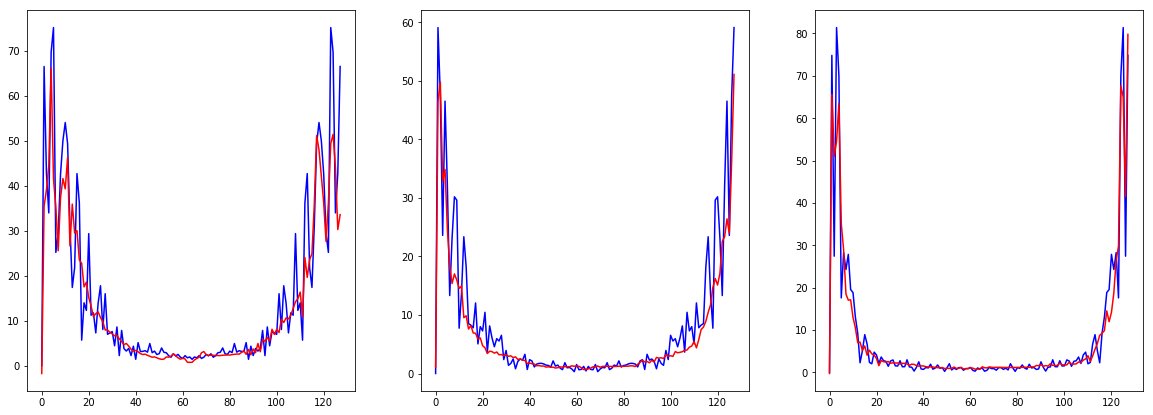

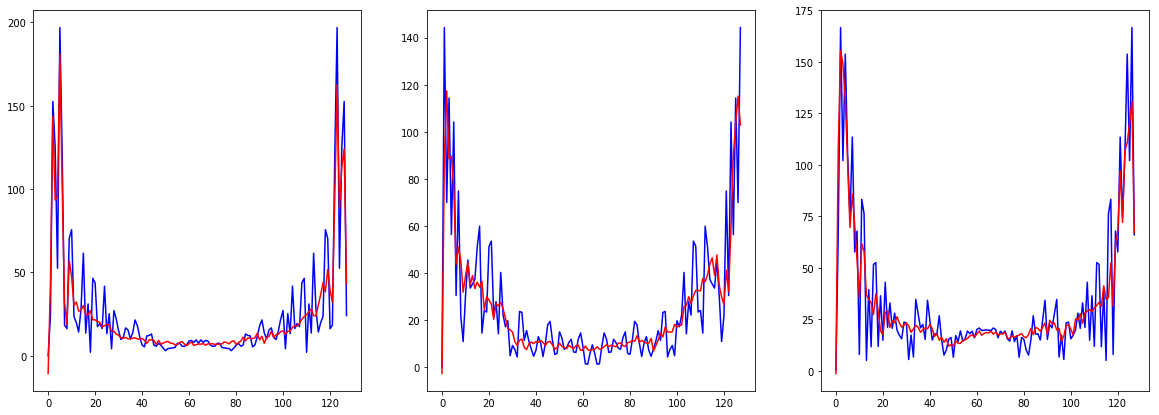

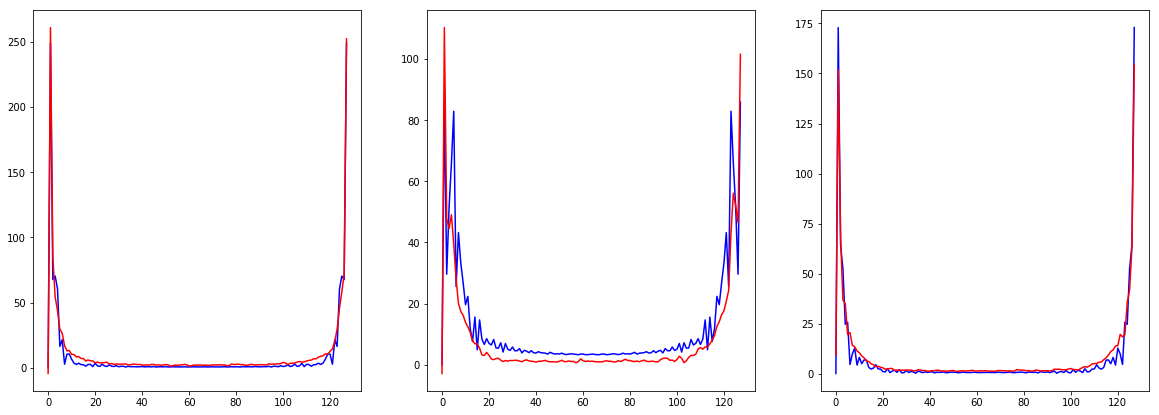

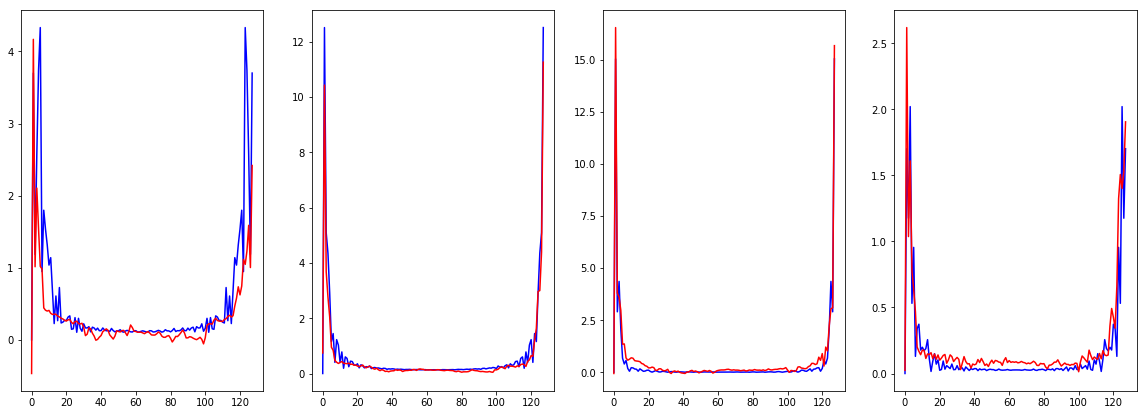

In [94]:
sample = 32
gyroy = gyroModel.predict(gyro_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gyro_train[sample,:,channel],'b')
    plot(gyroy[0,:,channel],'r')
linearAccy = linearAccModel.predict(linearAcc_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(linearAcc_train[sample,:,channel],'b')
    plot(linearAccy[0,:,channel],'r')
gravityy = gravityModel.predict(gravity_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gravity_train[sample,:,channel],'b')
    plot(gravityy[0,:,channel],'r')
gameVecy = gameVecModel.predict(gameVec_train[sample].reshape(1,128,4))
fig=plt.figure(figsize=(20,7))
for channel in range(4):
    plt.subplot(1,4,channel+1)
    plot(gameVec_train[sample,:,channel],'b')
    plot(gameVecy[0,:,channel],'r')